In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_cc")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    for i in range(1, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)
    return np.mean(periods)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_cc


In [2]:
p_names = ["Osc", "Bi-phase-osc", "Beat", "Bi-period-osc", "Bi-stat-osc"]
coords = [[1.1, 0.3], [1.7, 0.8], [1.4, 0.6], [1.1, 0.5], [2.1, 0.8]]

for i in range(len(p_names)):
    p = p_names[i]
    data[p]["coordinates"] = coords[i]

NameError: name 'data' is not defined

Osc


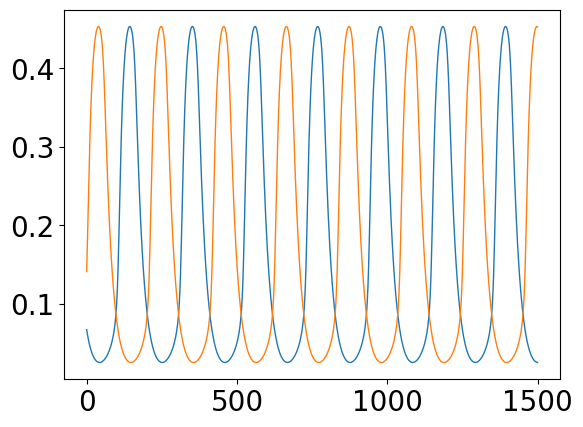

20.77584033613446 20.754716981132084
Beat


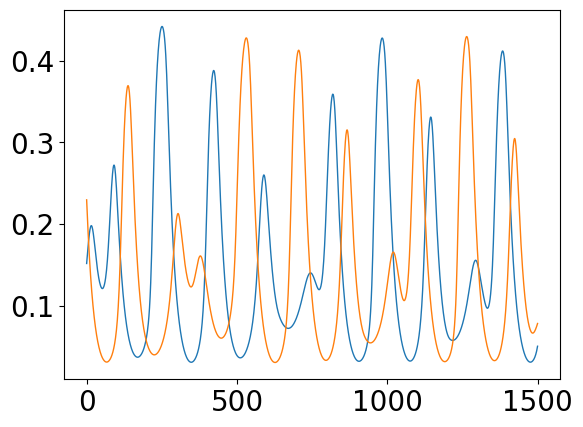

14.269496402877698 14.113513513513515
Bi-phase-osc


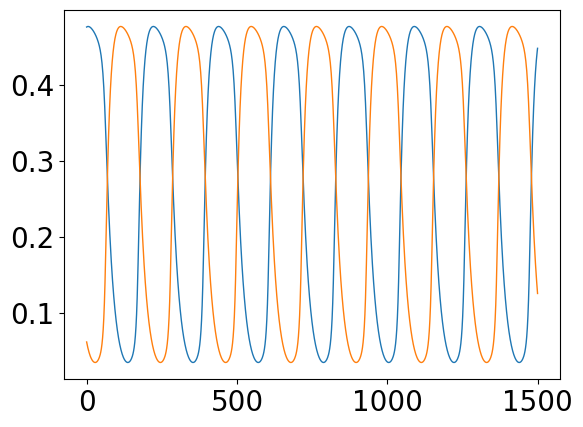

21.68771929824561 21.6875
Bi-stat-osc


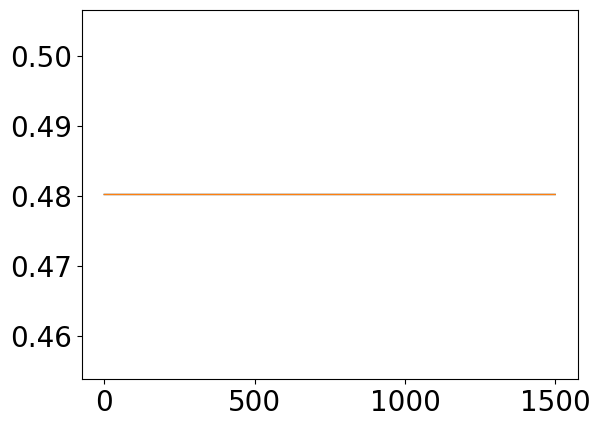

15.316846986089644 15.316846986089644
Bi-period-osc


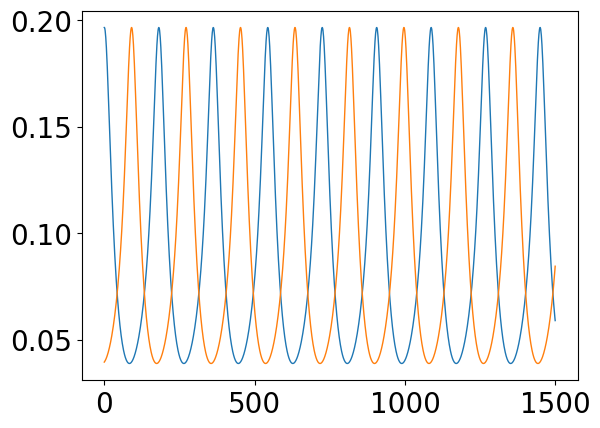

21.30064516129033 21.30021551724138


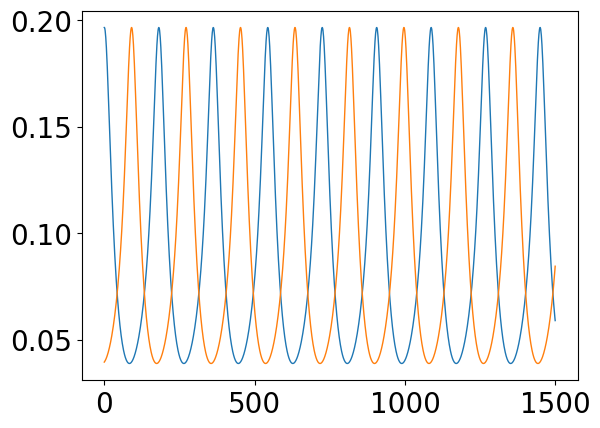

17.490636042402826 17.47566137566137


In [3]:
coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

if True:
    data = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        data[p]["delay"] = 9.5

        if "Bi-period" in p:
            data[p]["control"] = [[None, None], [None, None]]
            data[p]["state"] = [[None, None], [None, None]]
            data[p]["init_state"] = [None, None]
            data[p]["weight"] = [[1., 1.], [1., 1.]]
            data[p]["dur/per"] = [[1000., 20], [1000., 20]]
            data[p]["target_period"] = [20., 20.]
        else:
            data[p]["control"] = [None, None]
            data[p]["state"] = [None, None]
            data[p]["init_state"] = None
            data[p]["weight"] = [1., 1.]
            data[p]["dur/per"] = [1000., 20]
            data[p]["target_period"] = 20.


duration = 10000.
dt = 0.1


test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,:500] = 5.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,:500] = -5.

test_input_phase = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_phase = np.vstack( ([test_input_phase]*N))
test_input_phase[0,:500] = np.sin(2.*np.pi*np.arange(0,50,dt)/20.)
test_input_phase[1,:500] = - np.sin(2.*np.pi*np.arange(0,50,dt)/20.)

for pi in range(len(p_names)):

    if "Bi" in p_names[pi]:
        continue

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    #model.params["exc_ext"] = test_input_minus
    # minus: async after long time / beat after long time
    # plus: async after long time / beat after long time
    # none: async after long time / beat after long time

    model.params.K_gl = coupling
    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    per0 = get_period(-model.exc[0,601:], dt)
    per1 = get_period(-model.exc[1,601:], dt)
    data[p]["target_period"] = np.mean([per0, per1])

    print(per0, per1)   

if True:
    p = "Bi-phase-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_phase
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"] = [einit, iinit]

    per0 = get_period(model.exc[0,601:], dt)
    per1 = get_period(model.exc[1,601:], dt)
    data[p]["target_period"] = np.mean([per0, per1])

    print(per0, per1)

##########################################

if True:
    p = "Bi-stat-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"] = [einit, iinit]

    model.params["exc_ext"] = test_input_minus
    model.run()

    per0 = get_period(model.exc[0,601:], dt)
    per1 = get_period(model.exc[1,601:], dt)
    data[p]["target_period"] = np.mean([per0, per1])

    print(per0, per1)

##########################################
if True:
    p = "Bi-period-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"][0] = [einit, iinit]

    model.params["exc_ext"] = test_input_phase
    model.run()

    per0 = get_period(model.exc[0,601:], dt)
    per1 = get_period(model.exc[1,601:], dt)
    data[p]["target_period"][0] = np.mean([per0, per1])

    print(per0, per1)

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"][1] = [einit, iinit]

    model.params["exc_ext"] = test_input_minus
    model.run()

    per0 = get_period(model.exc[0,601:], dt)
    per1 = get_period(model.exc[1,601:], dt)
    data[p]["target_period"][1] = np.mean([per0, per1])

    print(per0, per1)

In [9]:
controlmat = np.ones((N,2))
costmat = np.zeros((N,2))
costmat[:,0] = 1

it = 50
maxstr = 5

pr = np.arange(0,1001,20)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [5]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [40]:
data["Osc"]["weight"] = [1. * 1e-2, 1.* 1e-1]
data["Bi-phase-osc"]["weight"] = [1. * 1e-1, 1.]
data["Beat"]["weight"] = [1. * 1e-3, 1. * 1e-2]
data["Bi-stat-osc"]["weight"] = [1. * 1e-4, 1. * 1e-3]

data["Osc"]["dur/per"] = [600., 20]
data["Bi-phase-osc"]["dur/per"] = [600., 20]
data["Beat"]["dur/per"] = [600., 20]
data["Bi-stat-osc"]["dur/per"] = [600., 20]

In [64]:
it = 10

for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" in p:
        continue

    # ["Osc", "Bi-phase-osc", "Beat", "Bi-period-osc", "Bi-stat-osc"]
    if pi not in [1,2,3]: continue

    print("Point ", p)
      
    target_period = data[p]["target_period"]

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    nmaxdelay = model.getMaxDelay()
    print("target period, max delay = ", target_period, nmaxdelay)

    model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
    model.params.K_gl = coupling
        
    model.params.duration = data[p]["dur/per"][0]

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data[p]["init_state"][0]
    model.params["inh_init"] = data[p]["init_state"][1]

    model.run()
    
    int0 = 500
    int1 = int0 + int(data[p]["dur/per"][1]*target_period/dt)

    for wi, w2 in enumerate(data[p]["weight"]):

        print("w2 = ",w2)

        #if wi not in [0]: continue

        #for factor in np.random.random(10):
        for factor in [1]:

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1),
                                        cost_matrix=costmat, control_matrix=controlmat)
            
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_cc"] = 1. * factor

            model_controlled.maximum_control_strength = maxstr

            if True:
                if type(data[p]["control"][wi]) != type(None):
                    model_controlled.control = data[p]["control"][wi].copy()
                    model_controlled.update_input()

            model_controlled.grad_method = 1
            model_controlled.channelwise_optimization = True

            for l in range(7):
                for k in np.arange(-12., 12., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

        data[p]["control"][wi] = model_controlled.control.copy()
        data[p]["state"][wi] = model_controlled.get_xs()

    plot_control(data[p], data[p]["dur/per"][0], dt, 0)
    plot_control(data[p], data[p]["dur/per"][0], dt, 1)

with open(os.path.join(pickledir, '2n_wc_oscillations_cc.pickle'), 'wb') as f:
    pickle.dump(data, f)

Point  Bi-phase-osc
target period, max delay =  21.687609649122805 95
w2 =  0.1
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -133.40083389853197
Final cost : -133.40083389853413
Compute control for a deterministic system
Cost in iteration 0: -133.40083389853413
Final cost : -133.4008345389504
Compute control for a deterministic system
Cost in iteration 0: -133.4008345389504
Final cost : -133.40084198509877
Compute control for a deterministic system
Cost in iteration 0: -133.40084198509877
Final cost : -133.4011314761596
Compute control for a deterministic system
Cost in iteration 0: -133.4011314761596
Final cost : -133.40139191903833
Compute control for a deterministic system
Cost in iteration 0: -133.40139191903833
Final cost : -133.40139191903833
Compute control for a deterministic system
Cost in iteration 0: -133.40139191903833
Final cost : -133.40139191903833
Compute control for a deterministic system
Cost in iterati

Point  Osc
0.01


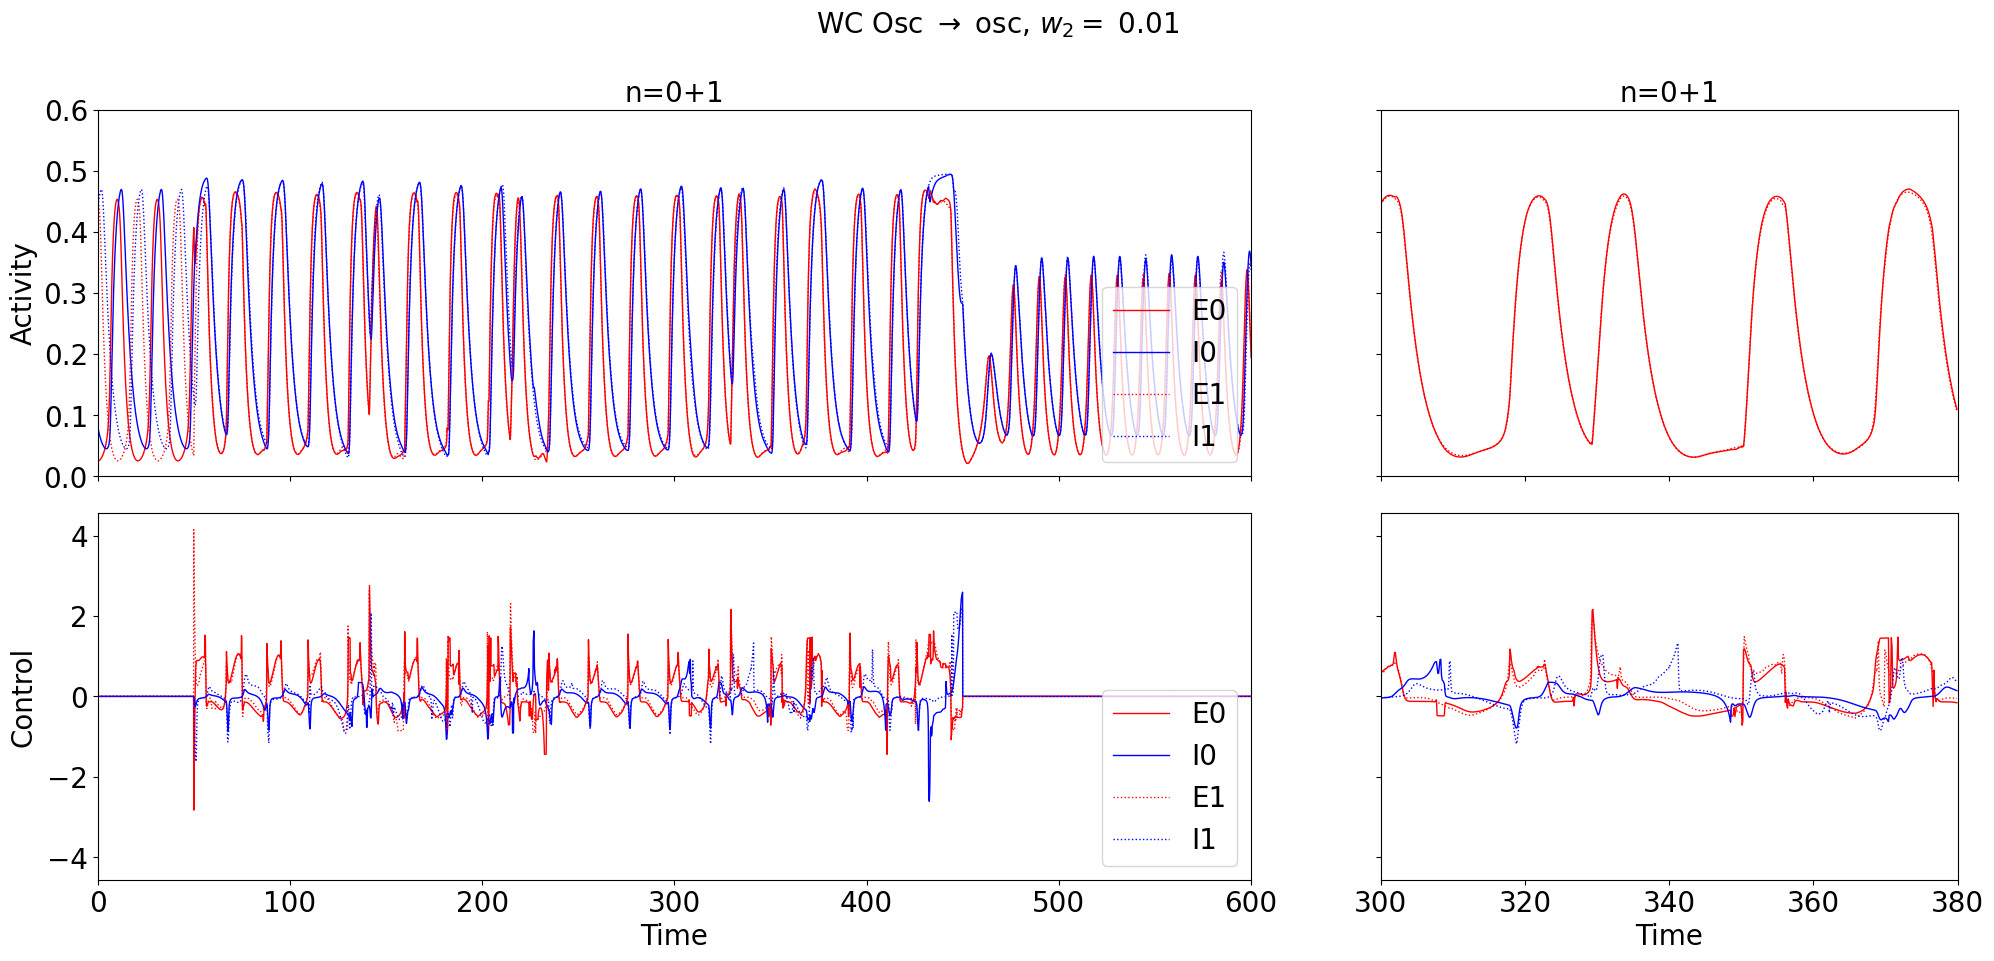

0.1


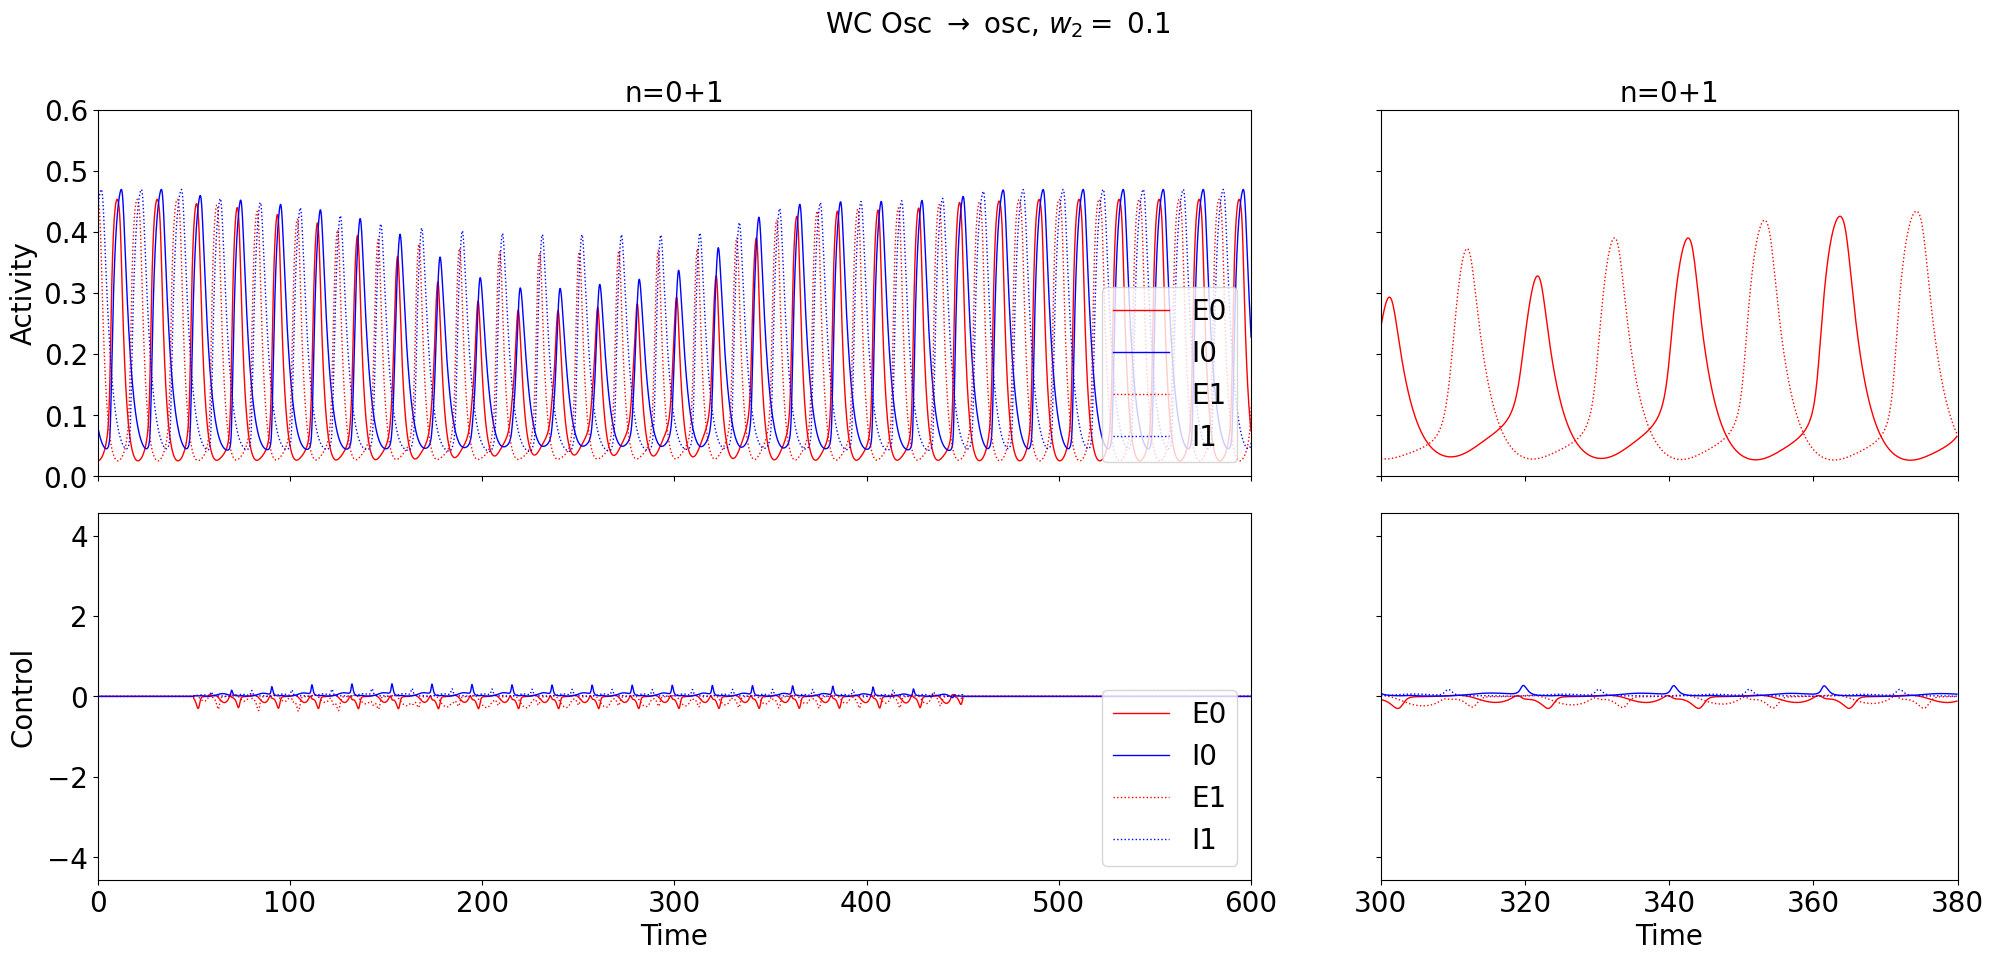

0.01


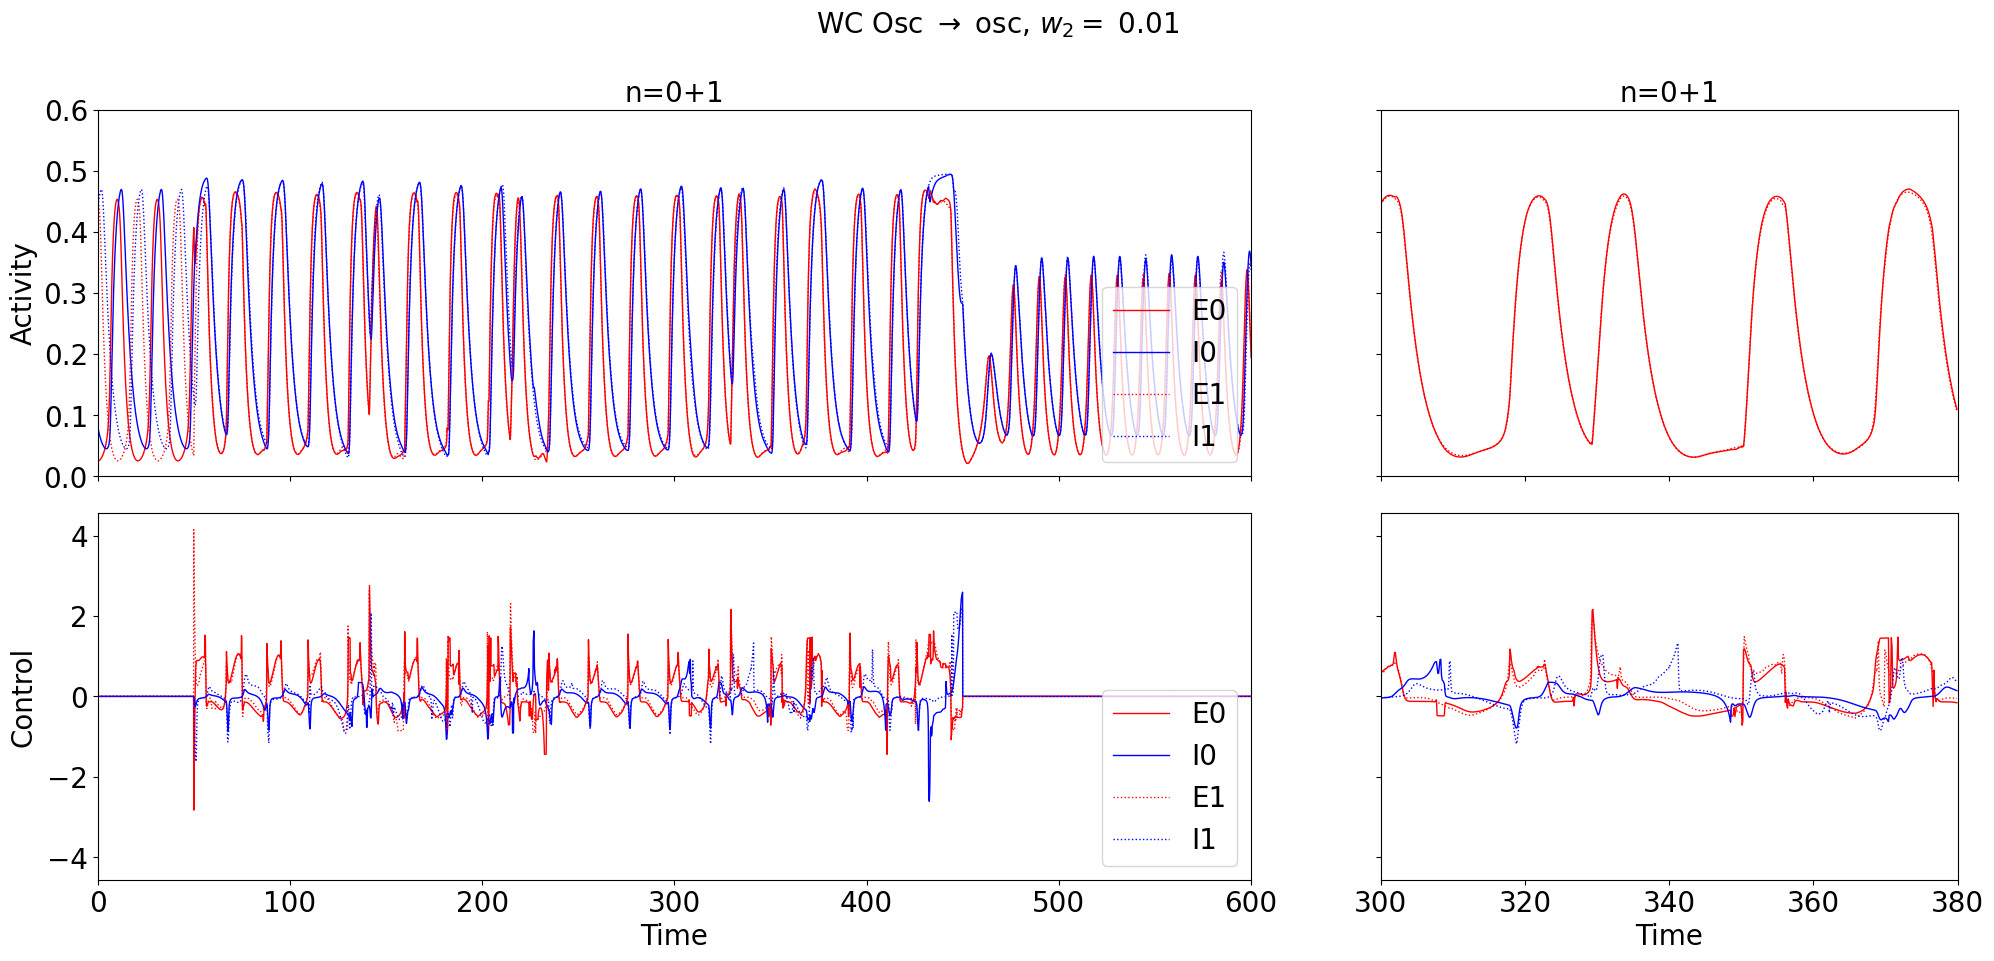

0.1


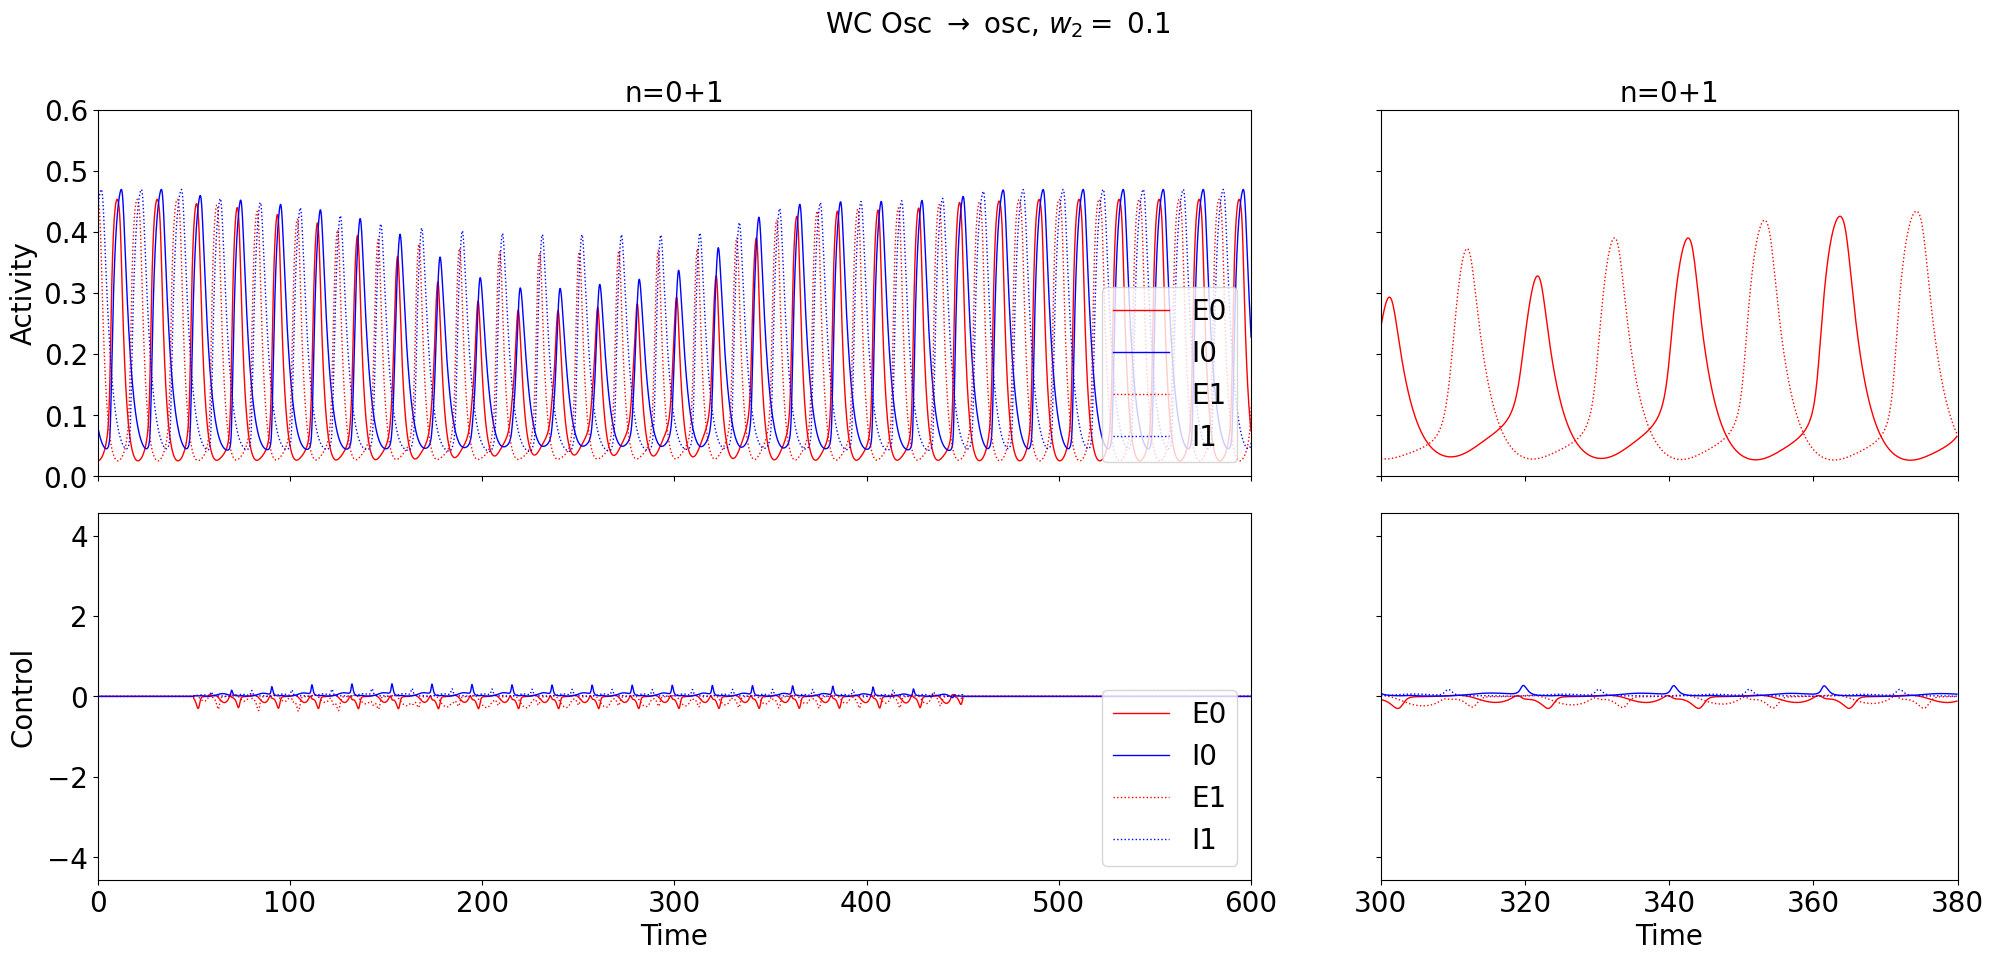

Point  Bi-phase-osc
0.1


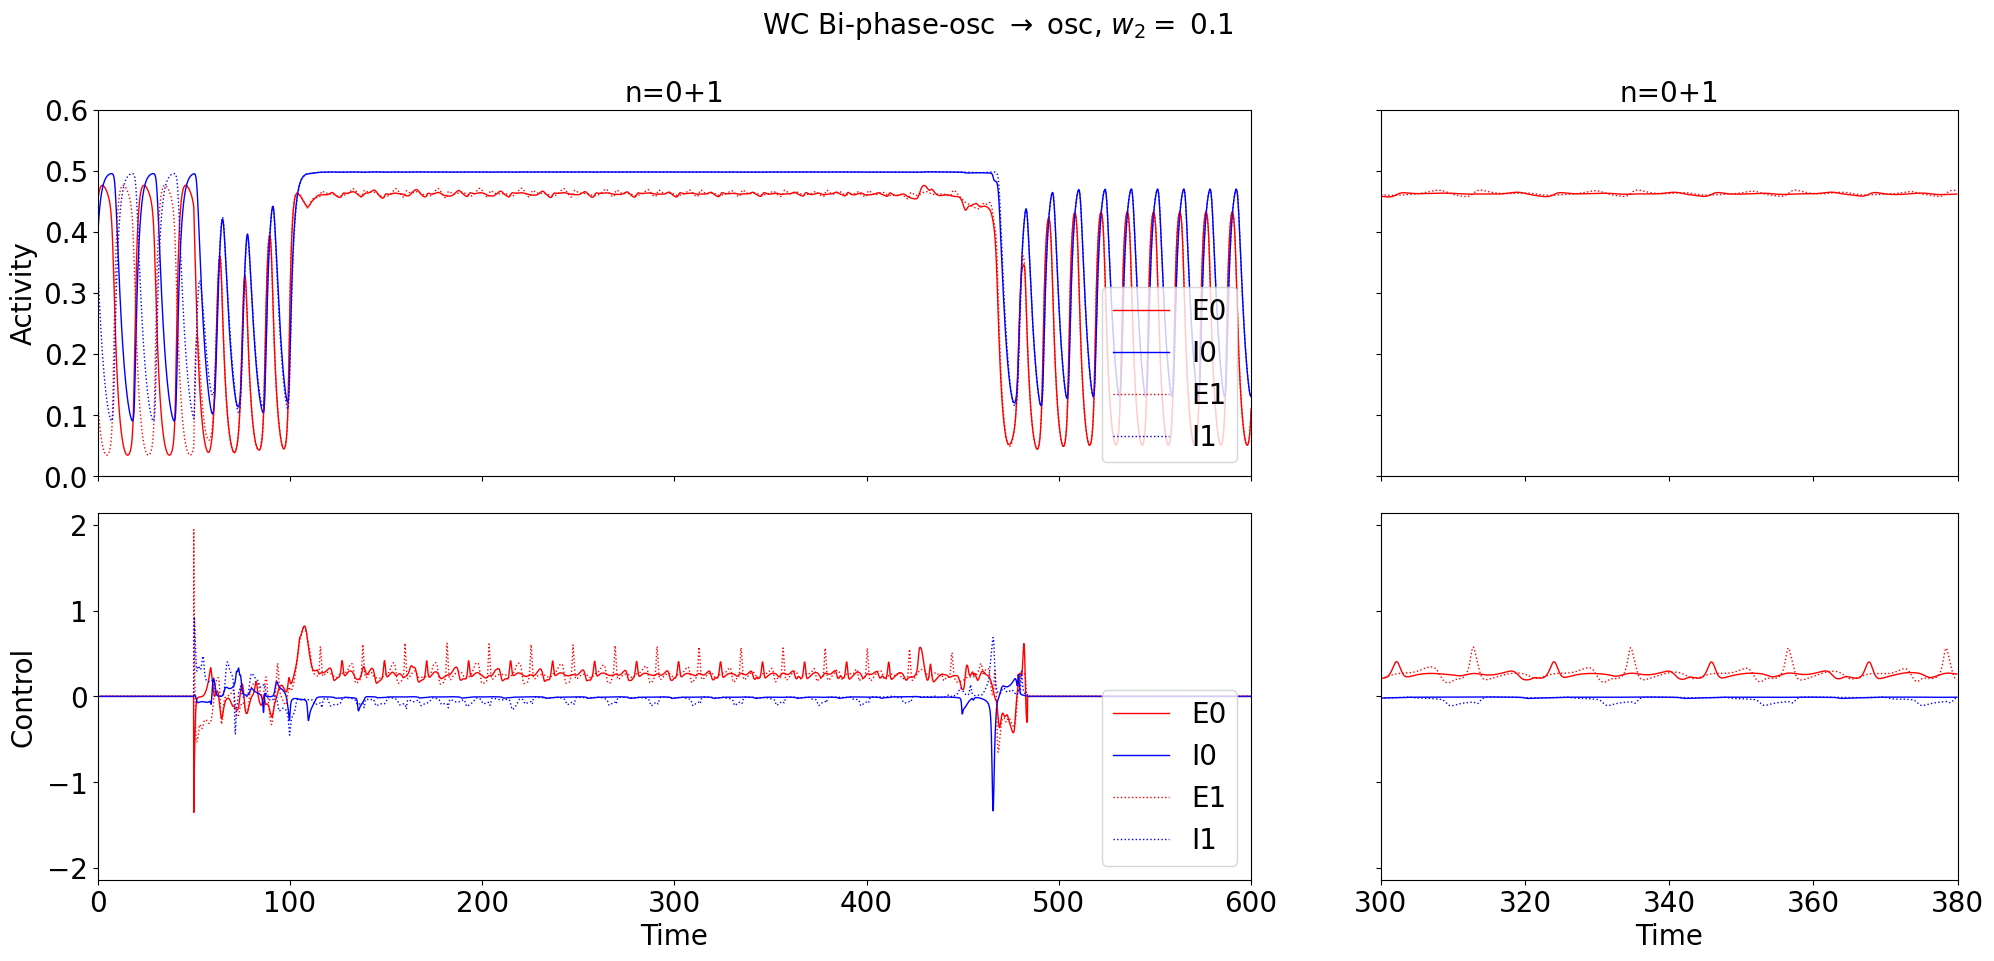

1.0


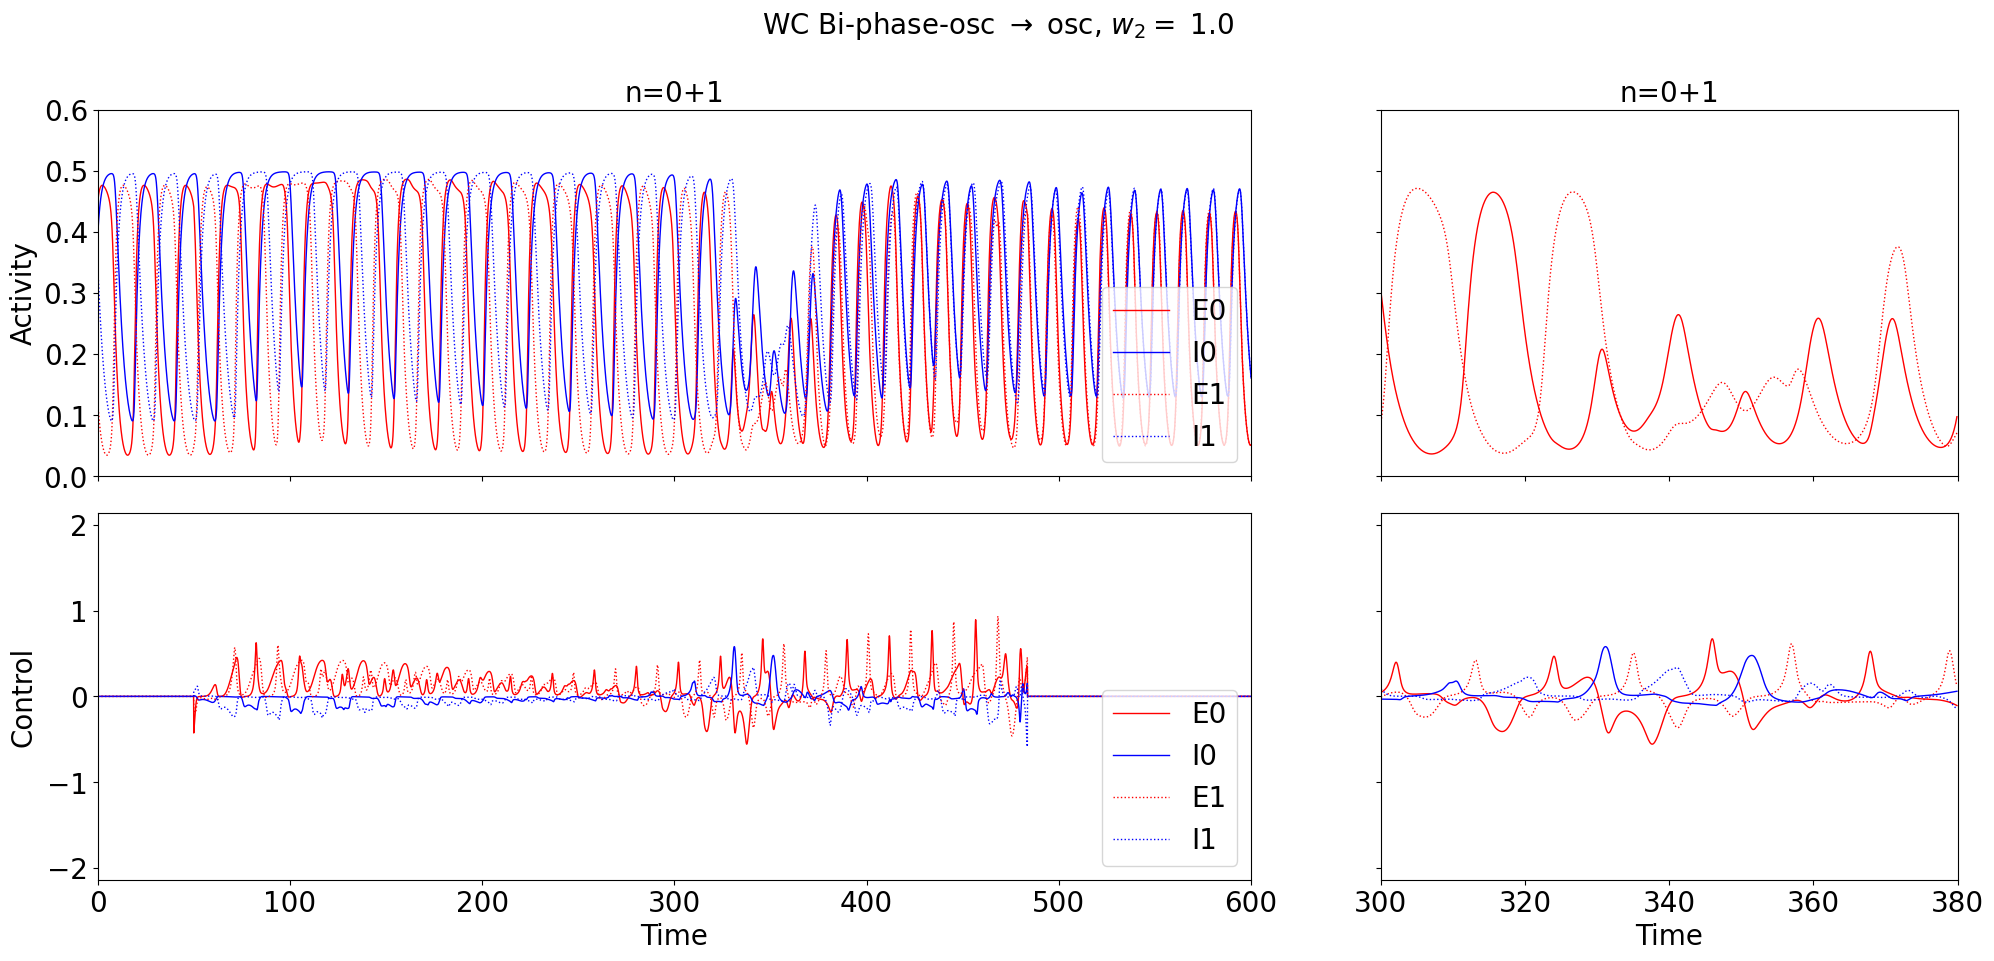

0.1


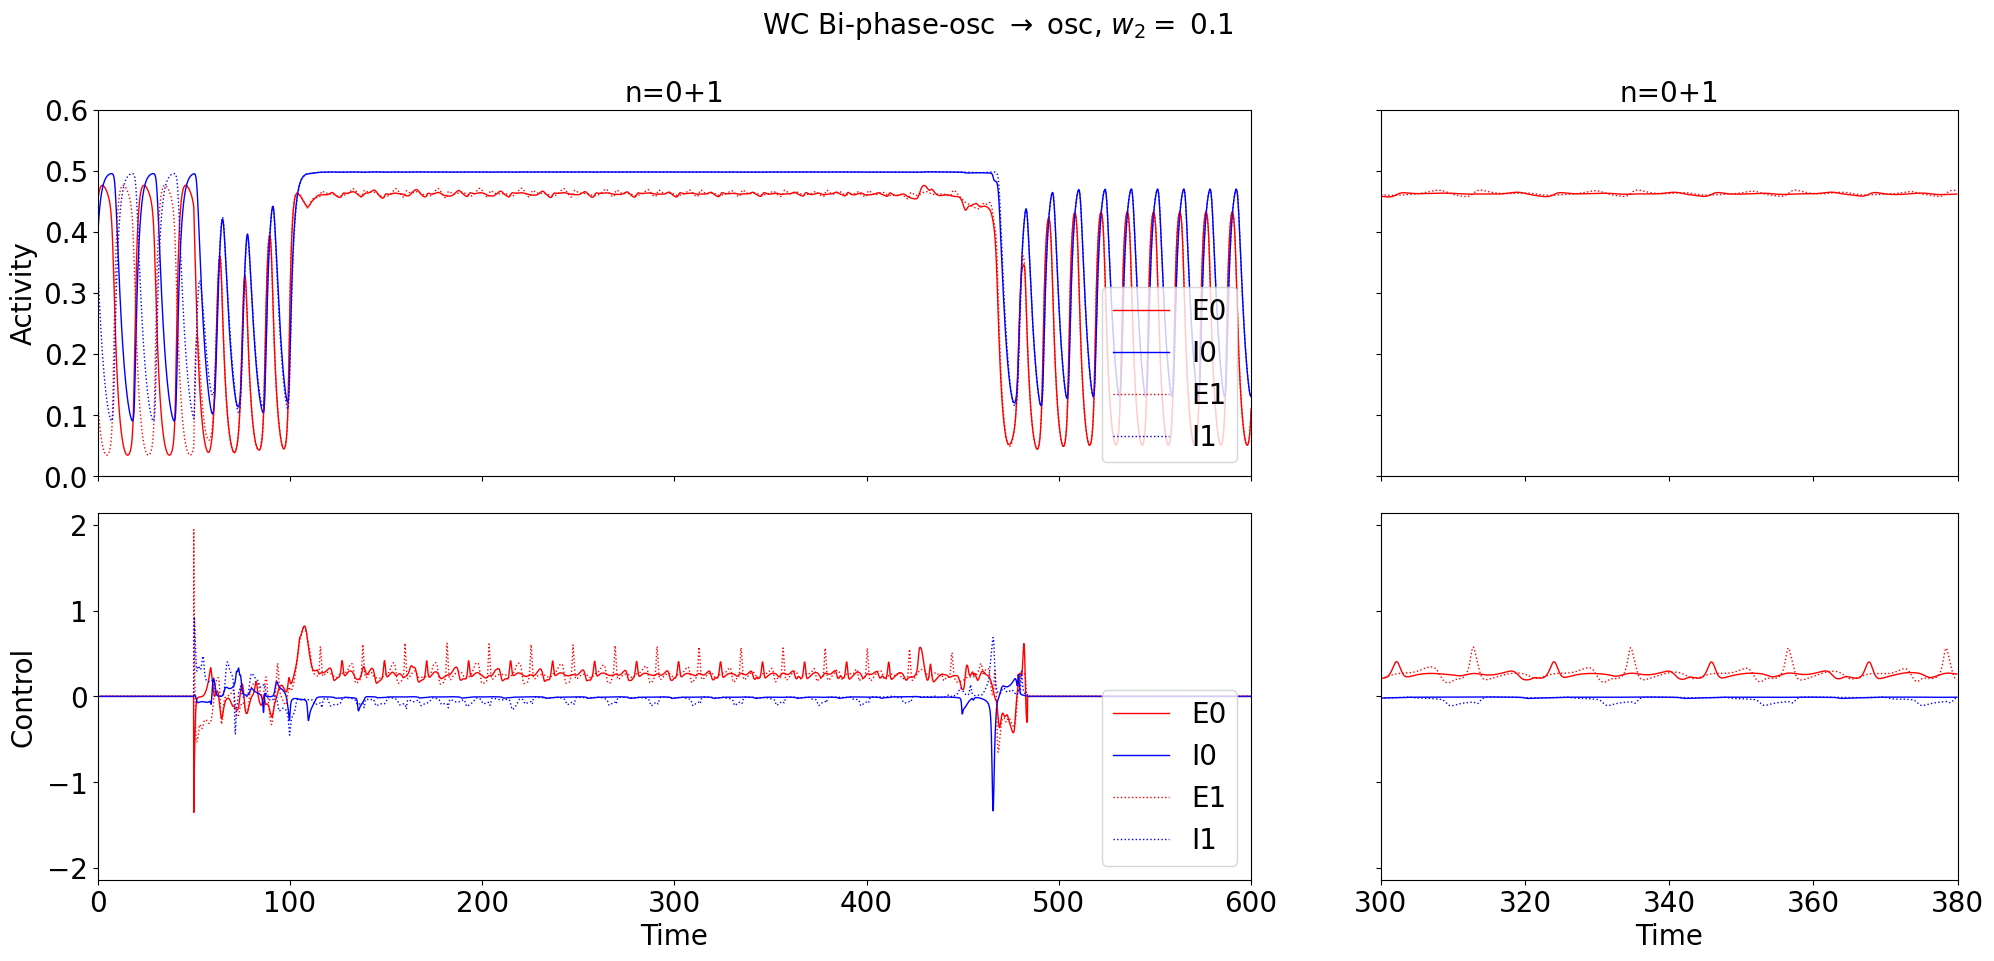

1.0


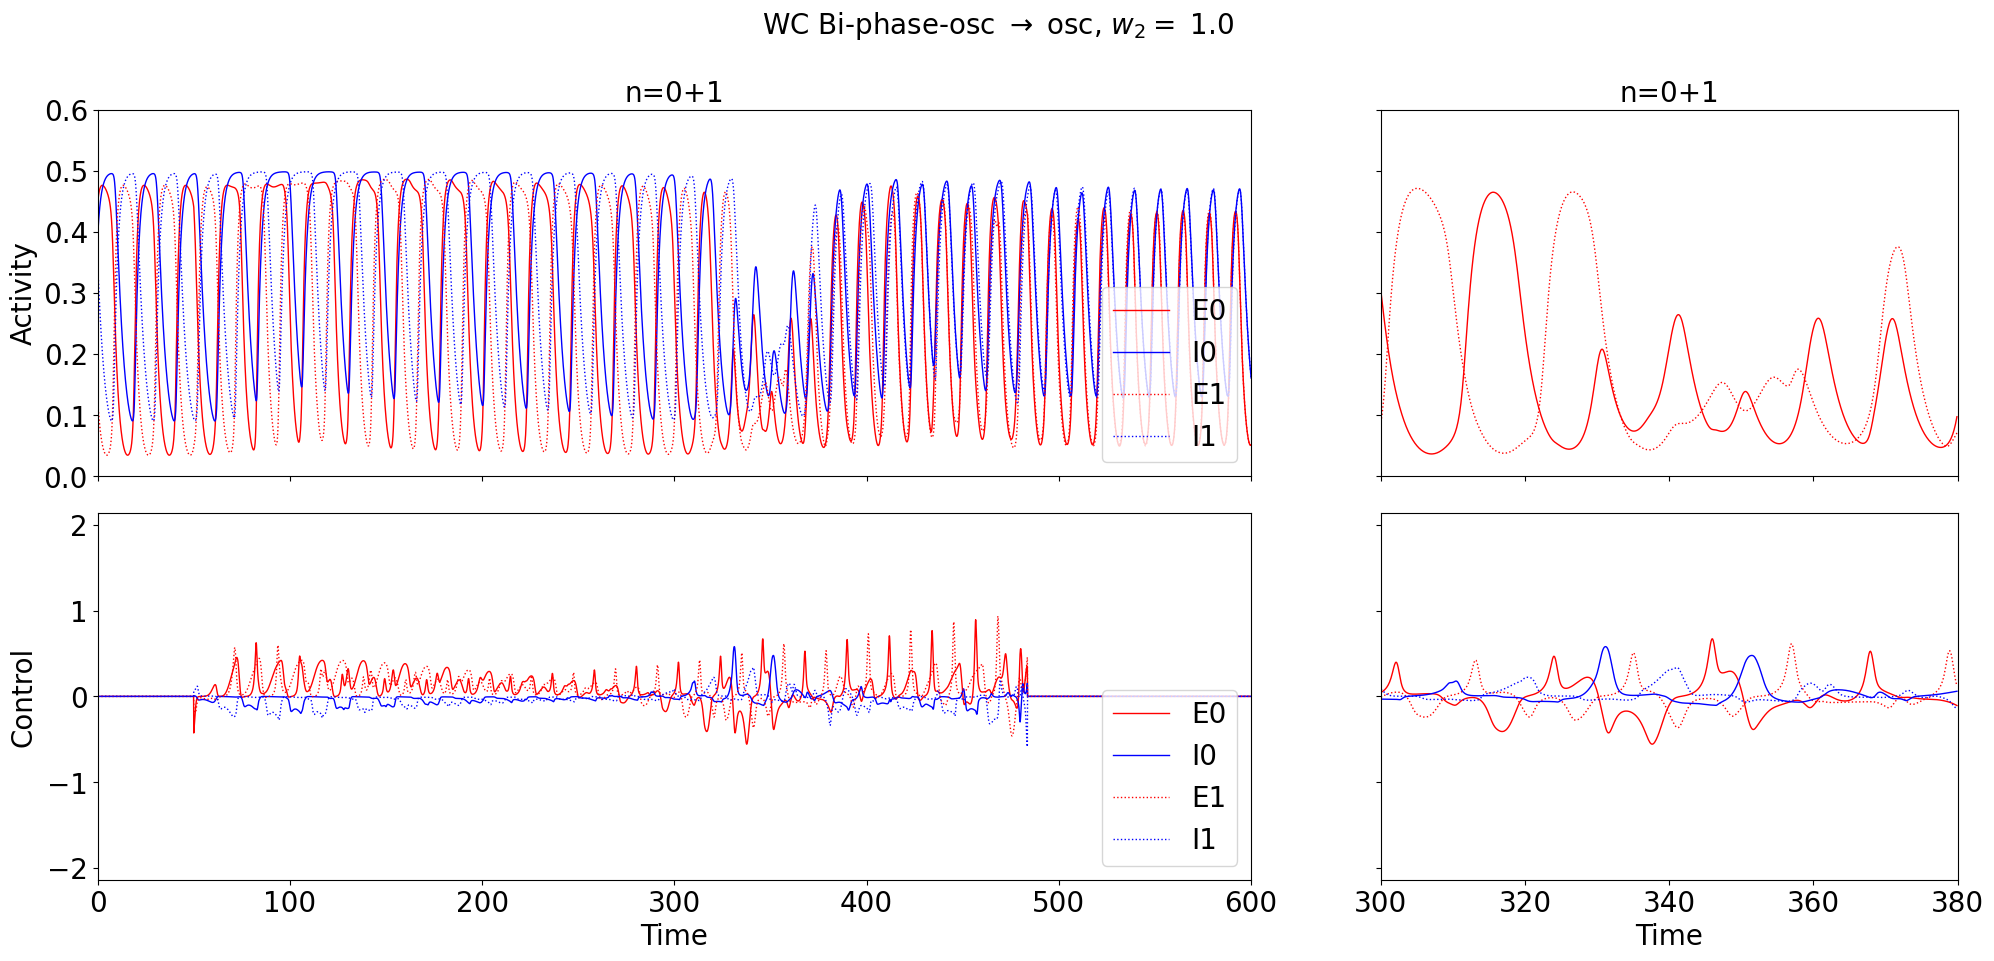

Point  Beat
0.001


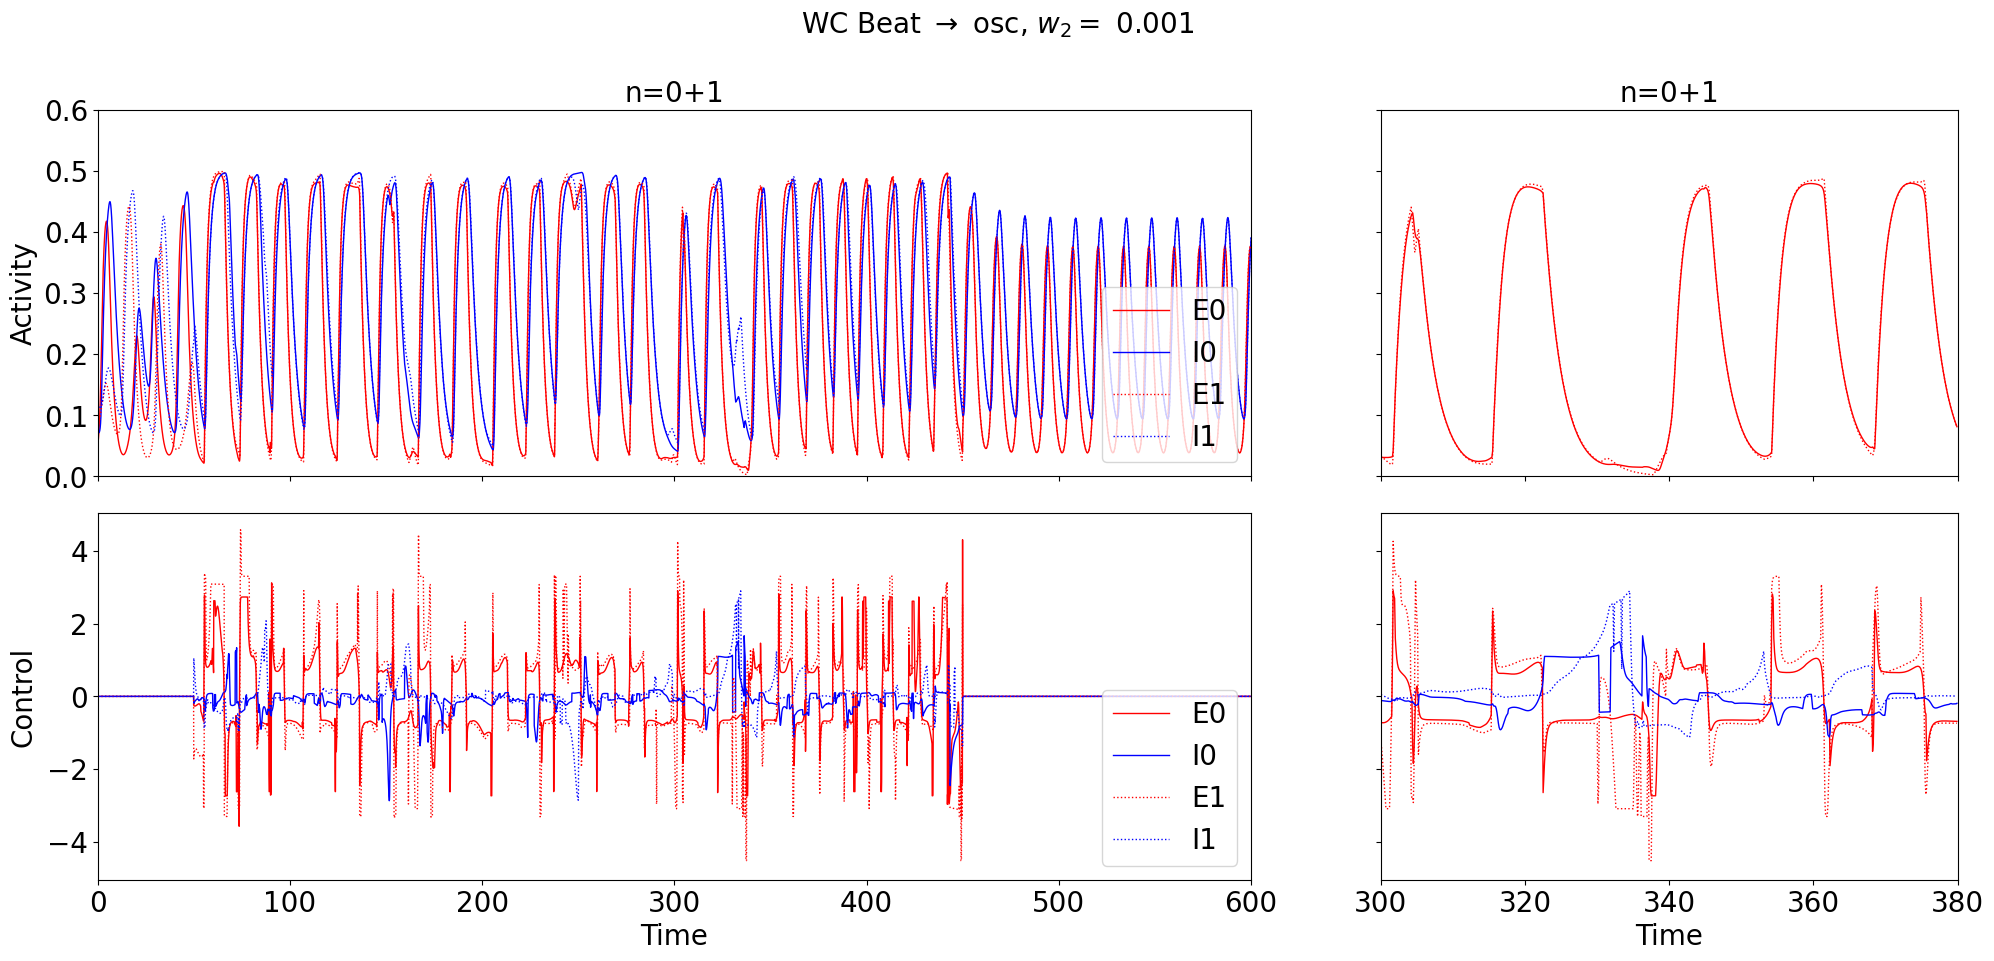

0.01


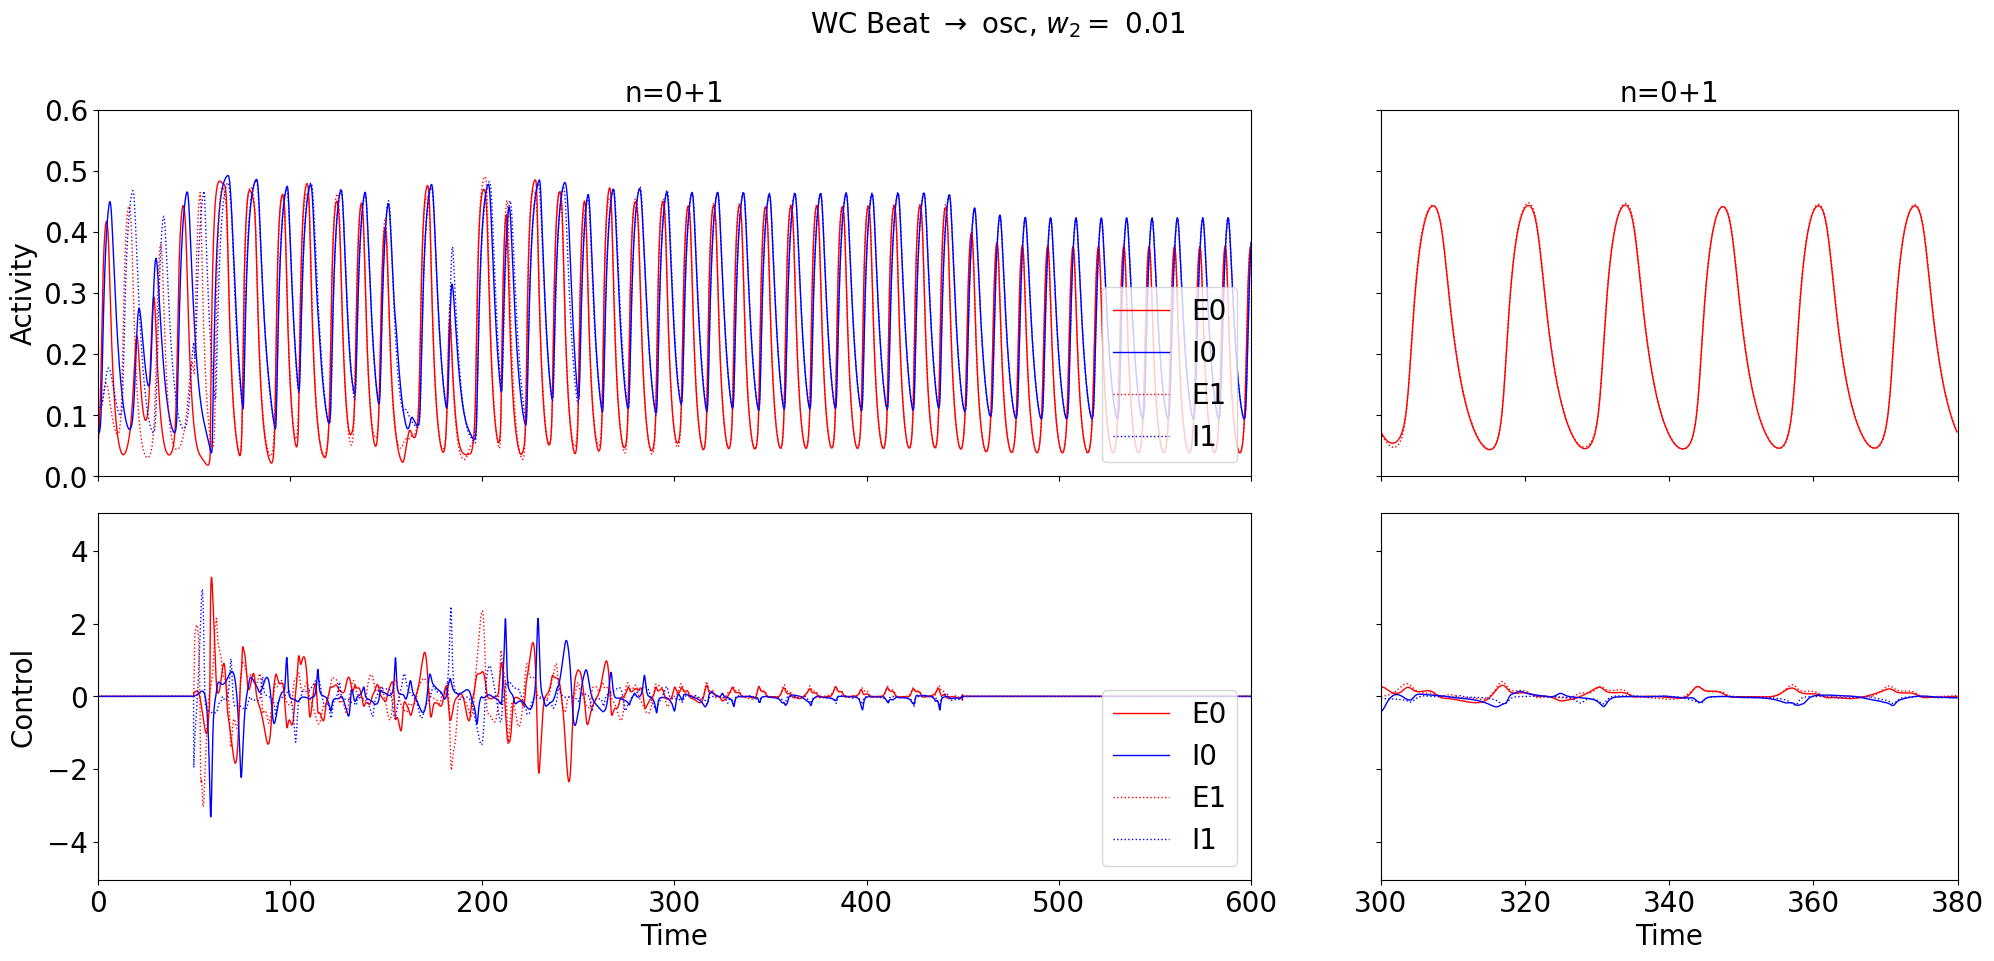

0.001


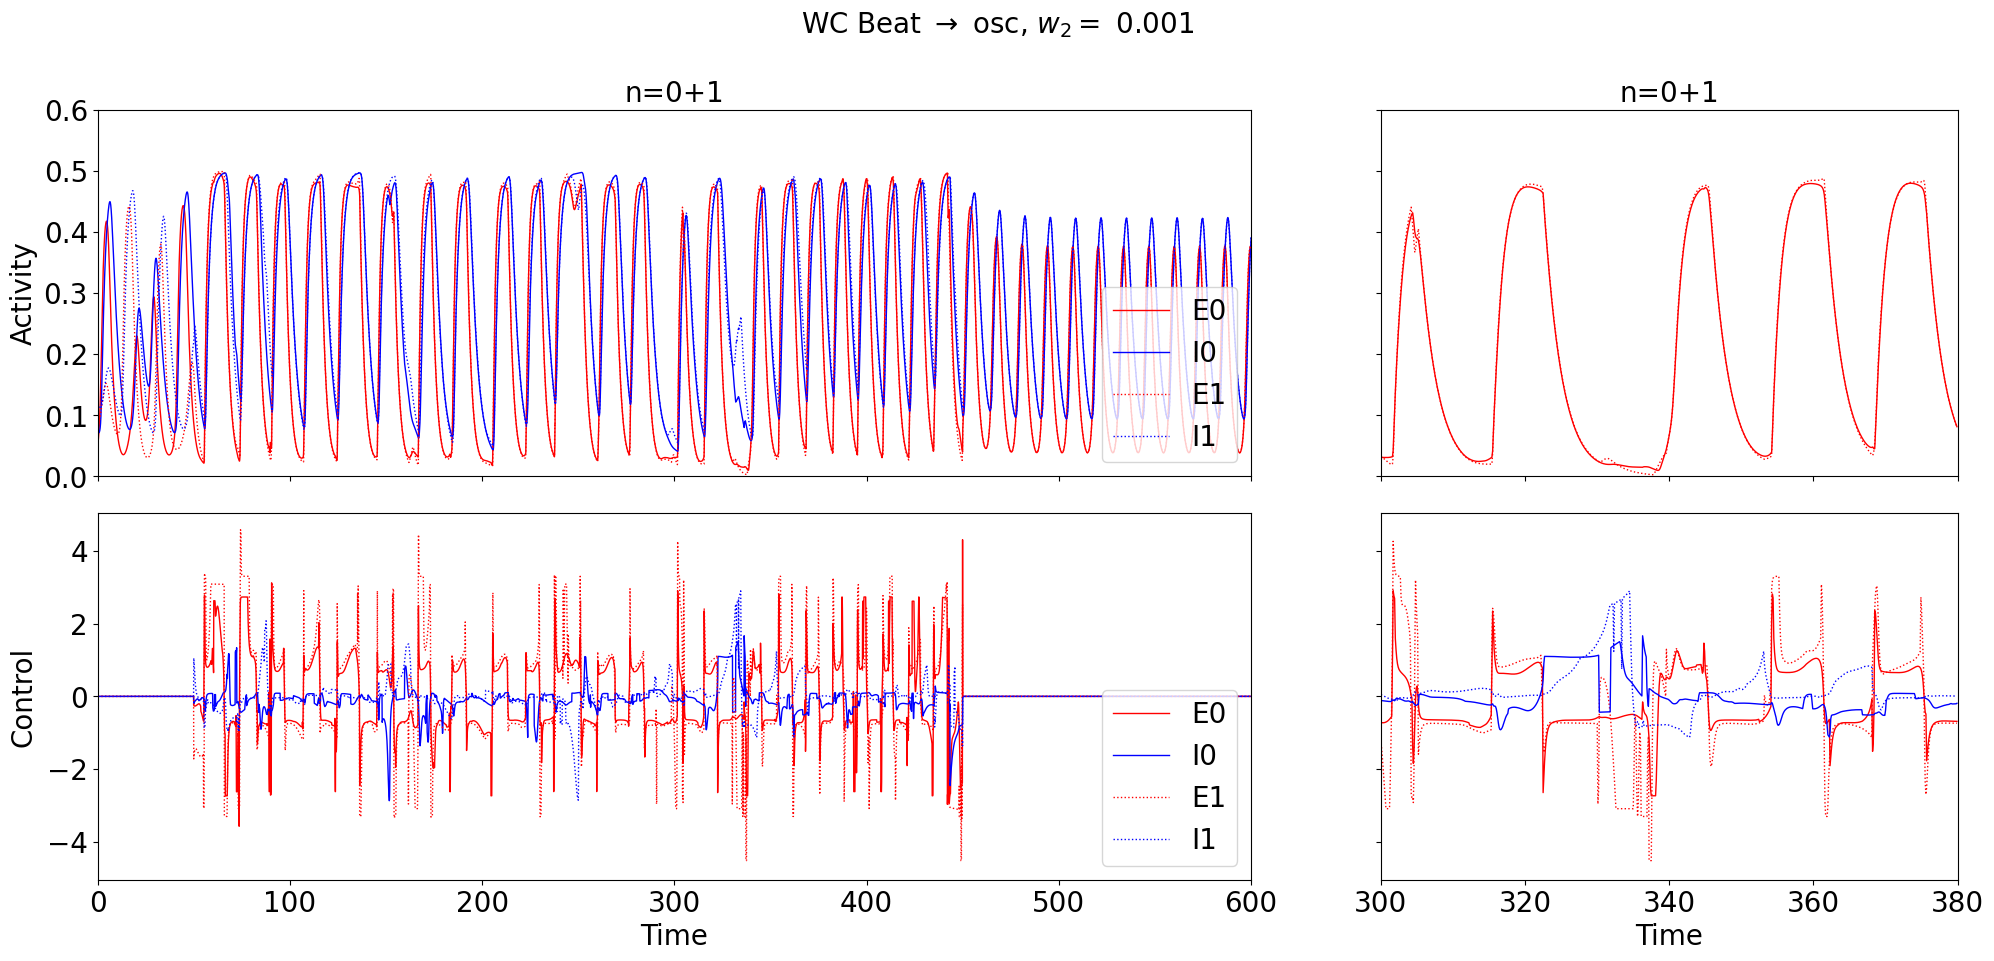

0.01


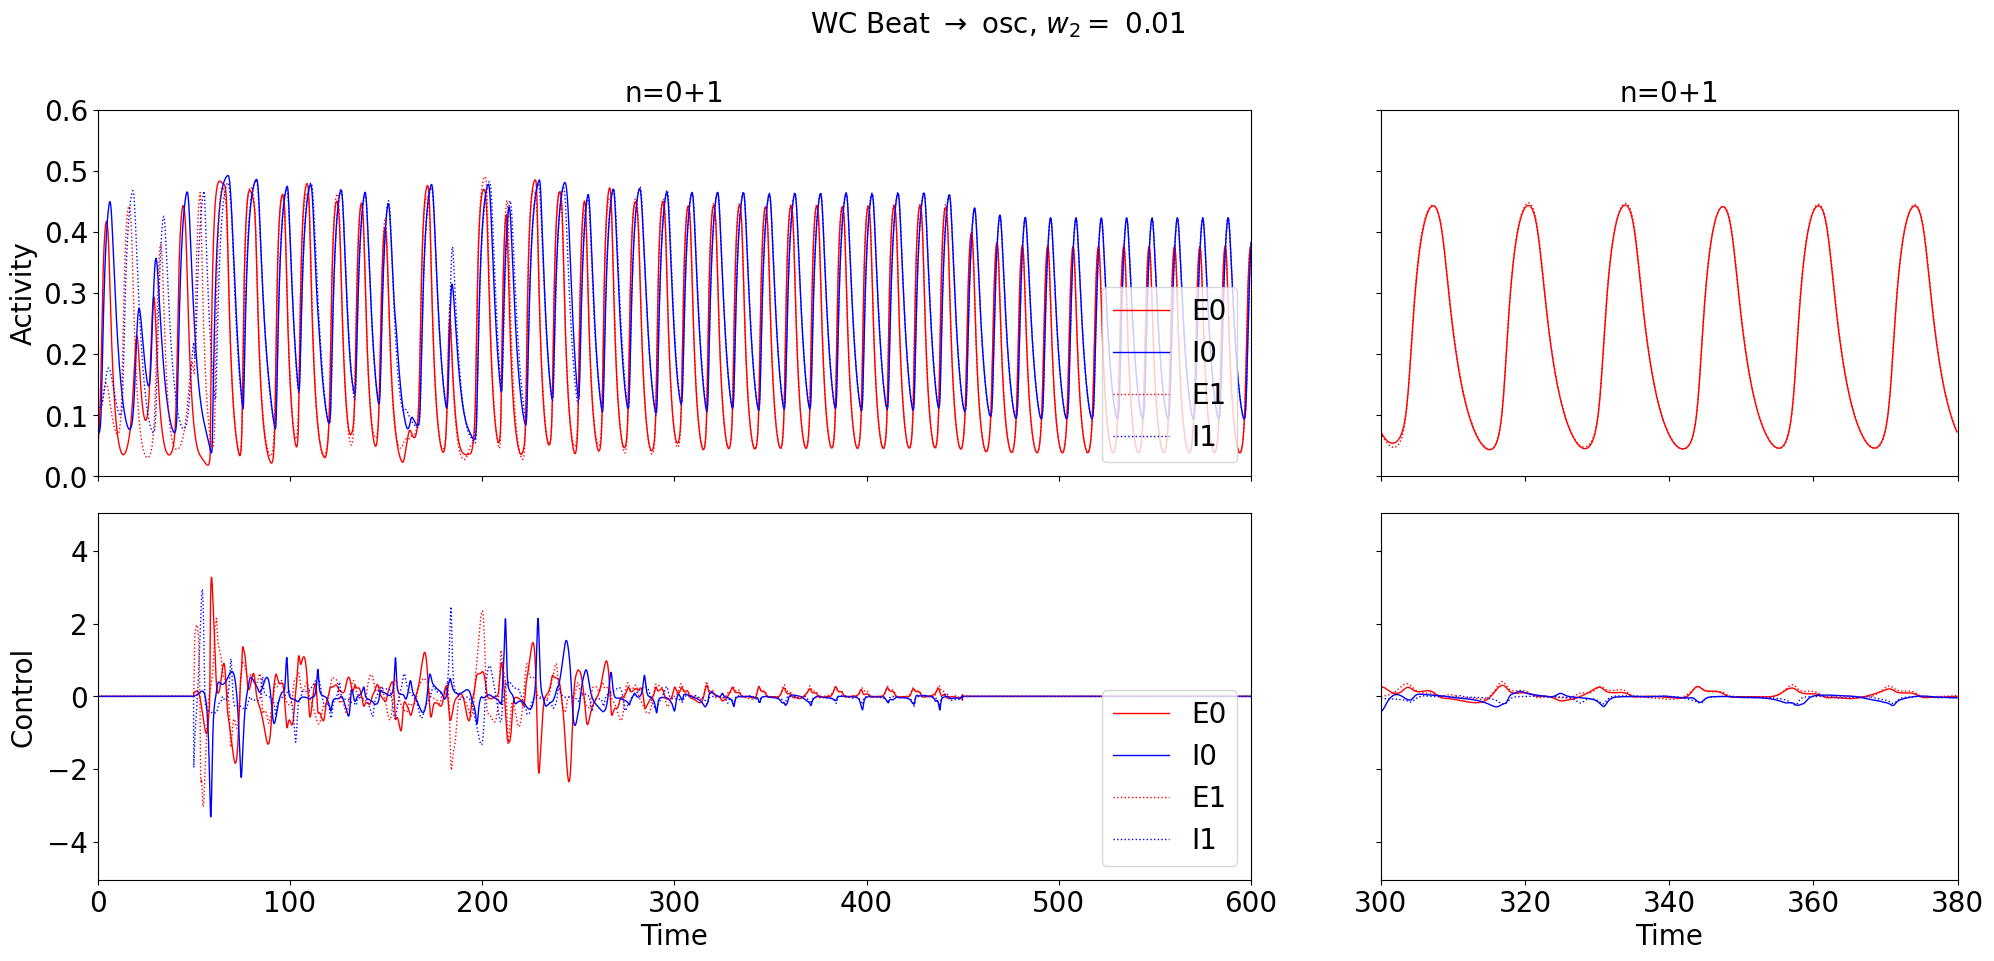

Point  Bi-stat-osc
0.0001


/tmp/ipykernel_72090/107291268.py:34: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax[1,0].set_ylim(y1lim)


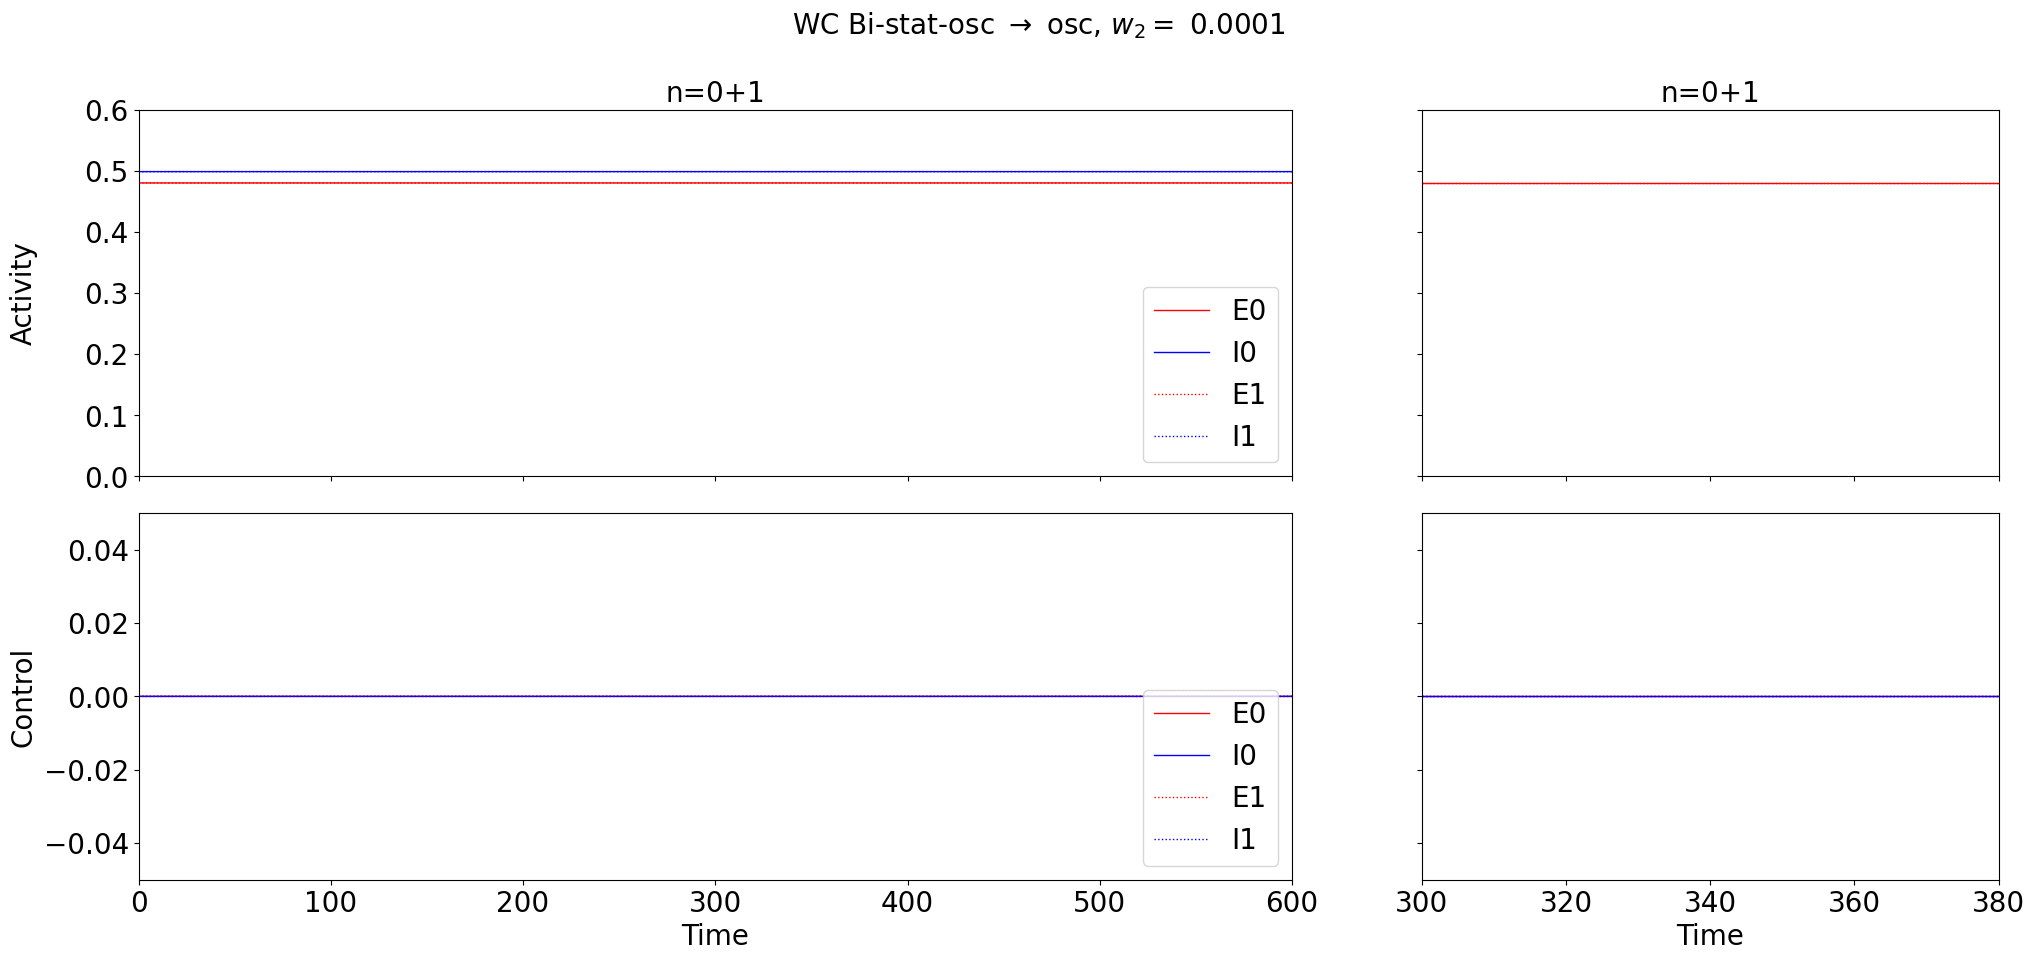

0.001


/tmp/ipykernel_72090/107291268.py:34: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax[1,0].set_ylim(y1lim)


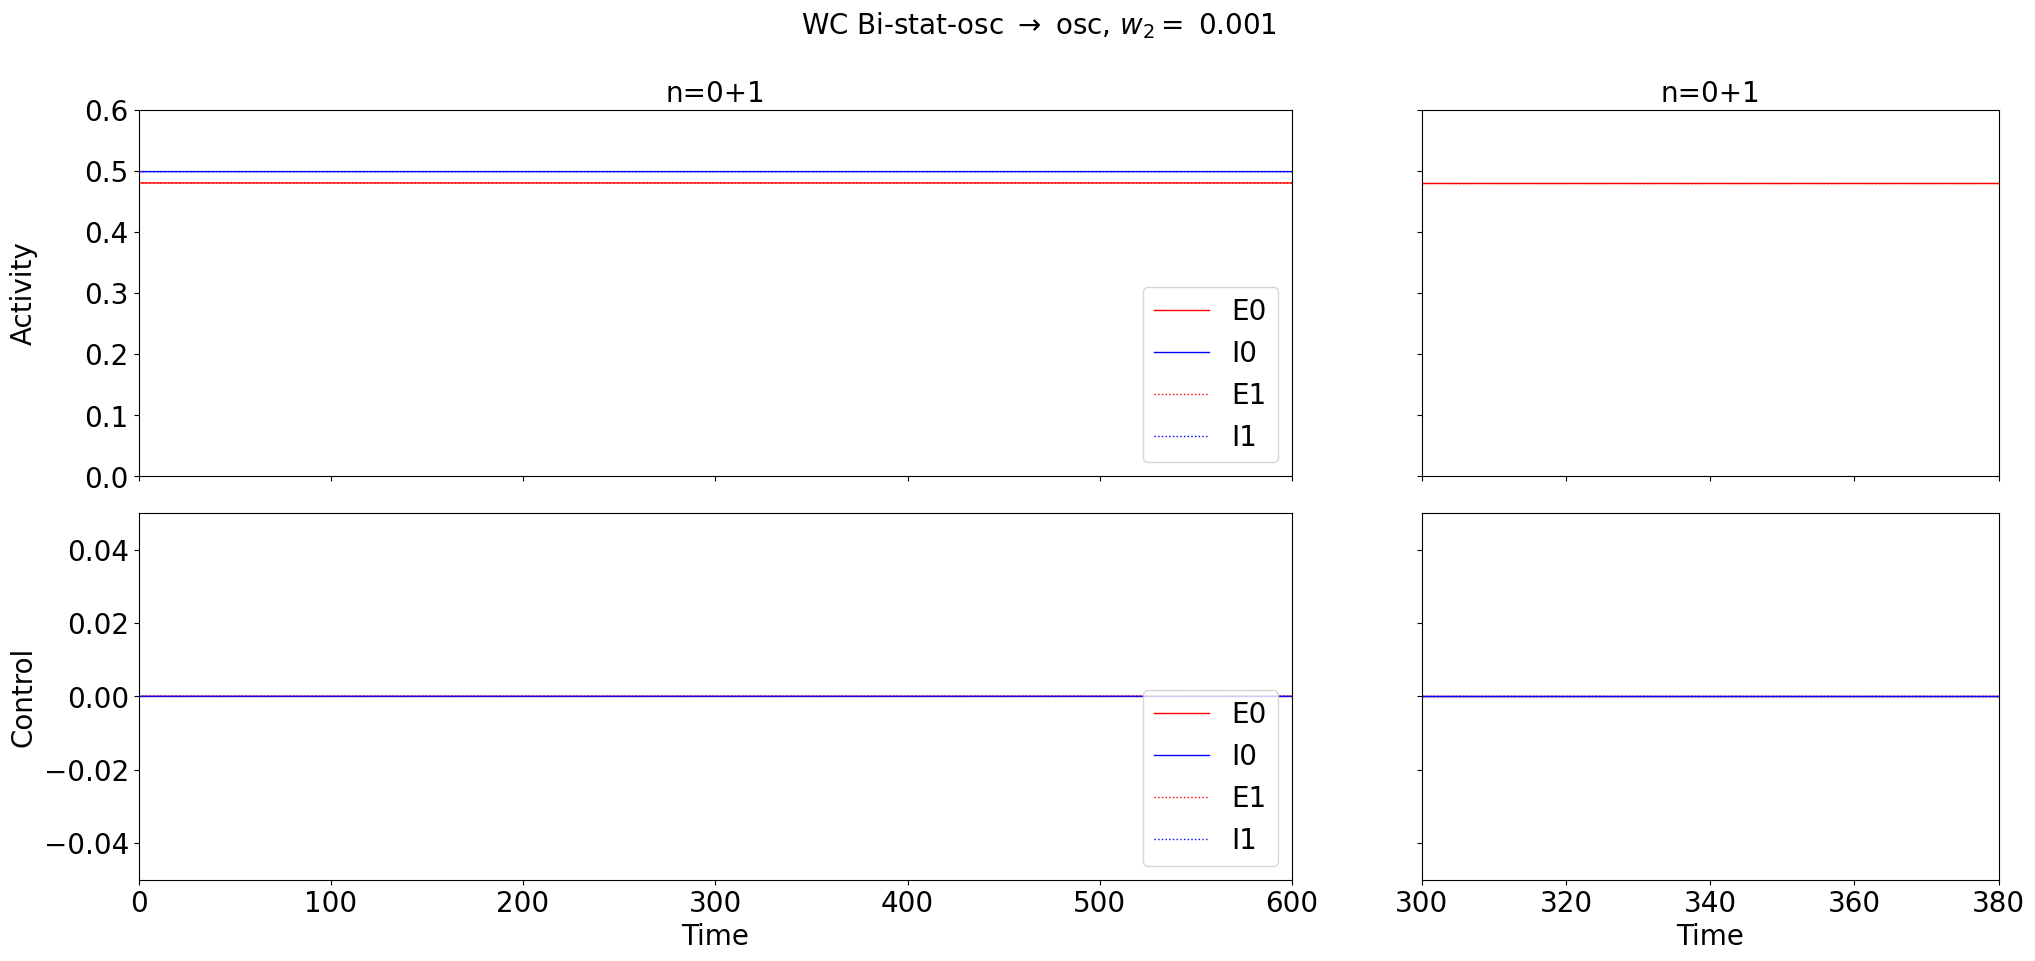

0.0001


/tmp/ipykernel_72090/107291268.py:34: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax[1,0].set_ylim(y1lim)


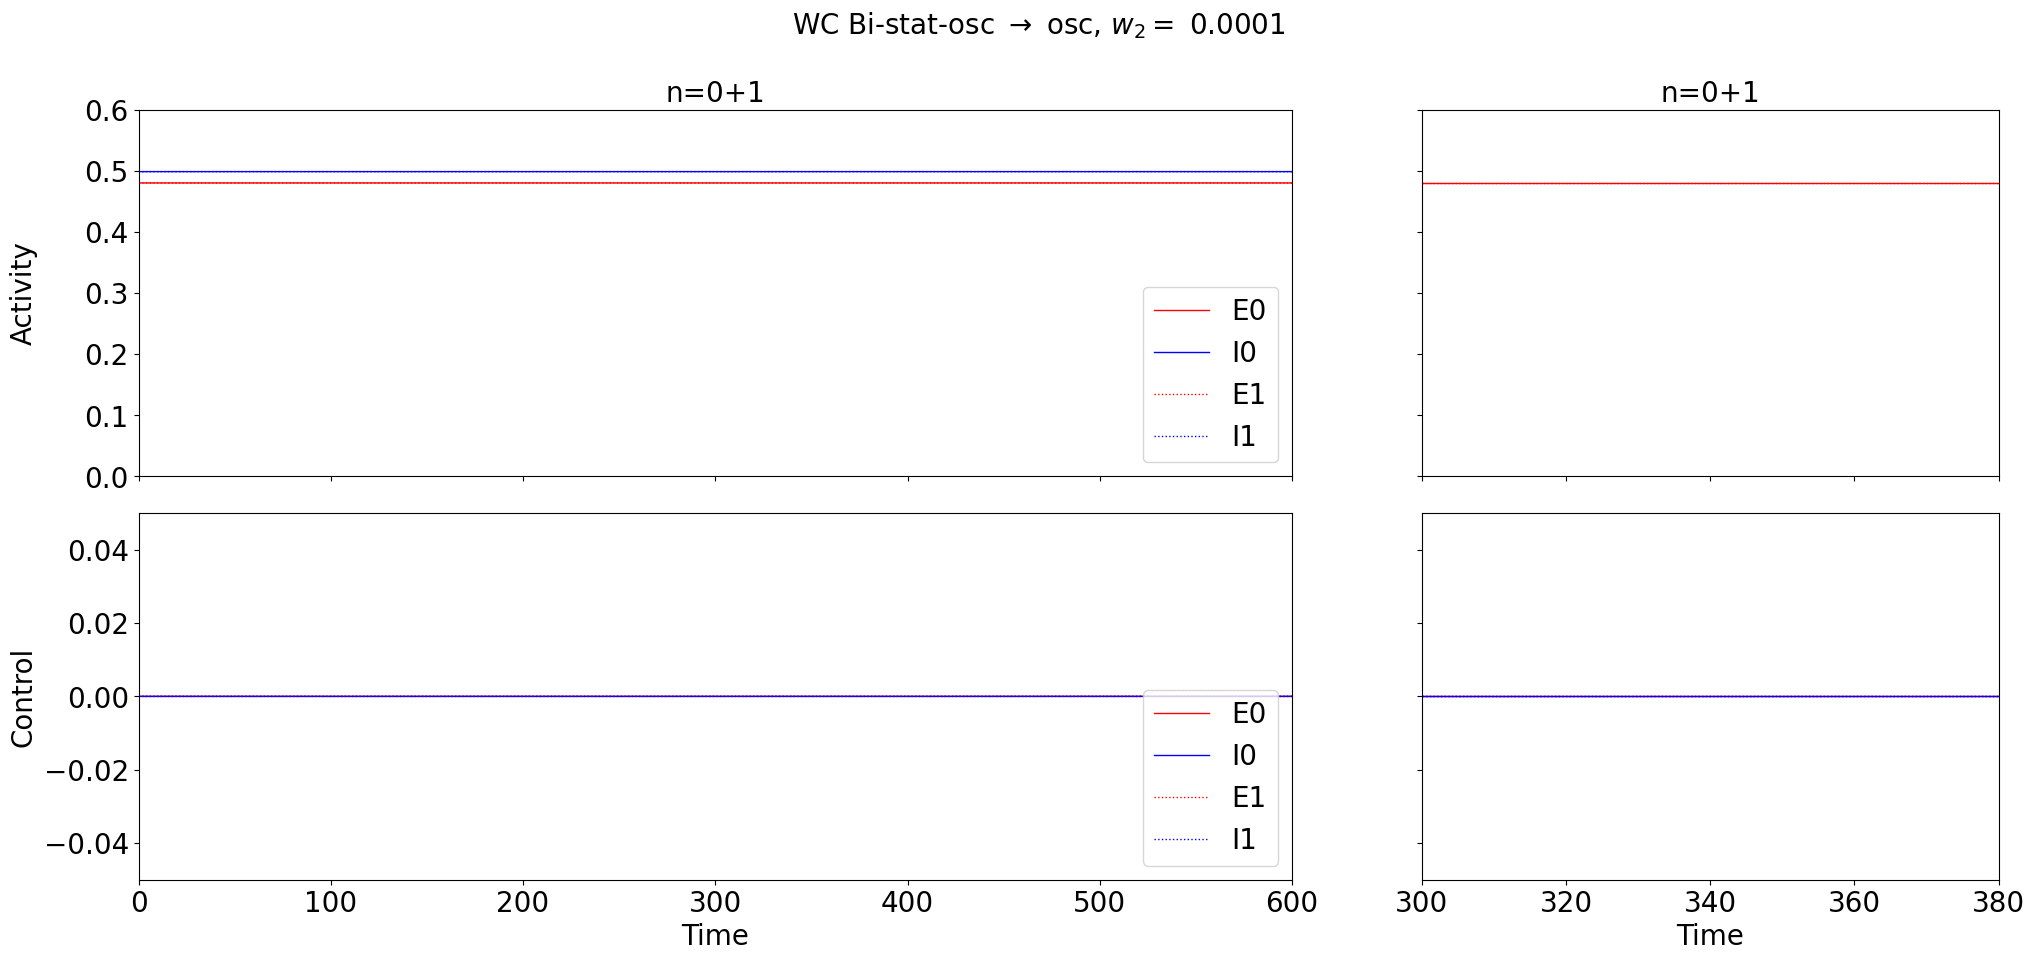

0.001


/tmp/ipykernel_72090/107291268.py:34: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax[1,0].set_ylim(y1lim)


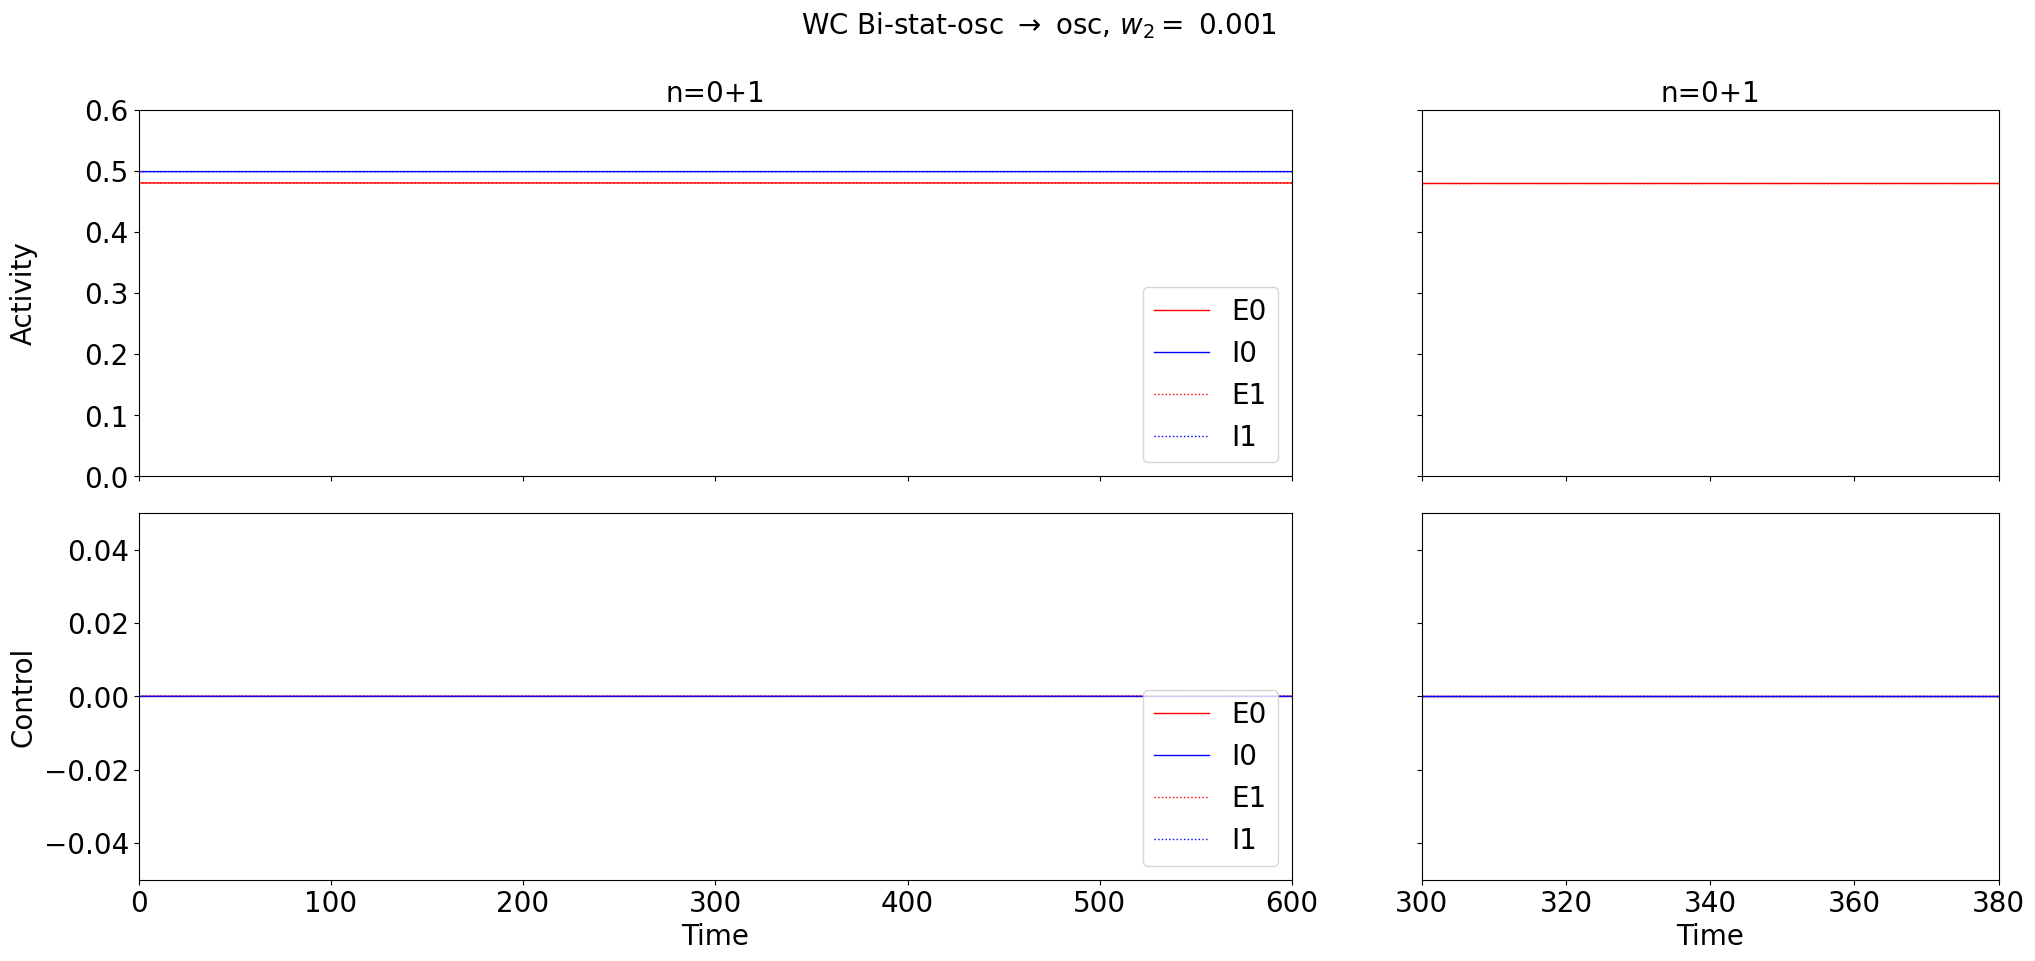

In [63]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" in p:
        continue

    print("Point ", p)   

    for i_init in range(2):

        for wi in range(len(data[p]["weight"])):

            print(data[p]["weight"][wi])

            filename = os.path.join(dir, str(p) + "_" + str(i_init) + "_" + str(wi) + ".png")
            title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][wi])
            plot_control(data[p],  data[p]["dur/per"][0], dt, wi, filename=filename, title=title)

In [7]:
y0lim = [0, 0.6]

def plot_control(data, dur, dt, wi, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][0])), np.amax(np.abs(data["control"][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0, 0].plot(time_array, data["state"][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0, 0].plot(time_array, data["state"][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])

    i0, i1 = 3000, 3800
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 1].plot(time_array, data["state"][wi][0,0,i0:i1], color="red", label="N0")
    ax[0, 1].plot(time_array, data["state"][wi][1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 1].plot(time_array, data["control"][wi][0,0,i0:i1], color="red")
    ax[1, 1].plot(time_array, data["control"][wi][1,0,i0:i1], color="red", linestyle=":")
    ax[1, 1].plot(time_array, data["control"][wi][0,1,i0:i1], color="blue")
    ax[1, 1].plot(time_array, data["control"][wi][1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0+1")
    ax[0,1].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [49]:
with open(os.path.join(pickledir, '2n_wc_oscillations_cc.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [7]:
with open(os.path.join(pickledir, '2n_wc_oscillations_cc.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['Osc', 'Bi-phase-osc', 'Beat', 'Bi-period-osc', 'Bi-stat-osc'])


In [10]:
y0lim = [0, 0.6]

def plot_control_bi(data, dur, dt, wi, ii, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][ii][0])), np.amax(np.abs(data["control"][ii][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0, 0].plot(time_array, data["state"][ii][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0, 0].plot(time_array, data["state"][ii][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][ii][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][ii][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])

    i0, i1 = 3000, 3800
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 1].plot(time_array, data["state"][ii][wi][0,0,i0:i1], color="red", label="N0")
    ax[0, 1].plot(time_array, data["state"][ii][wi][1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 1].plot(time_array, data["control"][ii][wi][0,0,i0:i1], color="red")
    ax[1, 1].plot(time_array, data["control"][ii][wi][1,0,i0:i1], color="red", linestyle=":")
    ax[1, 1].plot(time_array, data["control"][ii][wi][0,1,i0:i1], color="blue")
    ax[1, 1].plot(time_array, data["control"][ii][wi][1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0+1")
    ax[0,1].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [53]:
data["Bi-period-osc"]["weight"] = [[5. * 1e-2, 5. * 1e-1], [5. * 1e-2, 5. * 1e-1]]
data["Bi-period-osc"]["dur/per"] = [[600., 20], [600., 20]]

In [56]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" not in p:
        continue

    print("Point ", p)

    for i_init in range(2):

        target_period = data[p]["target_period"][i_init]

        model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
        nmaxdelay = model.getMaxDelay()
        print("target period, max delay = ", target_period, nmaxdelay)

        model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
        model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
        model.params.K_gl = coupling
            
        model.params.duration = data[p]["dur/per"][i_init][0]
        print("duration = ", model.params.duration)

        zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
        zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
        zero_control = np.vstack( ([zero_input]*N))
        zero_control = np.vstack( ([zero_input]*N))
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]

        model.params["exc_init"] = data[p]["init_state"][i_init][0]
        model.params["inh_init"] = data[p]["init_state"][i_init][1]

        model.run()
        
        int0 = 500
        int1 = int0 + int(data[p]["dur/per"][i_init][1]*target_period/dt)

        for wi, w2 in enumerate(data[p]["weight"][i_init]):

            print("w2 = ",w2)

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
            model_controlled.channelwise_optimization = True
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_cc"] = 1.

            model_controlled.maximum_control_strength = maxstr

            if True:
                if type(data[p]["control"][i_init][wi]) != type(None):
                    model_controlled.control = data[p]["control"][i_init][wi].copy()
                    model_controlled.update_input()

            for l in range(2):
                for k in np.arange(-6., 7., 1.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

            data[p]["control"][i_init][wi] = model_controlled.control.copy()
            data[p]["state"][i_init][wi] = model_controlled.get_xs()

        #plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 0, i_init)
        #plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 1, i_init)

with open(os.path.join(pickledir, '2n_wc_oscillations_cc.pickle'), 'wb') as f:
    pickle.dump(data, f)

Point  Bi-period-osc
target period, max delay =  21.300430339265855 95
duration =  600.0
w2 =  0.05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -114.56482711704031
Cost in iteration 20: -114.59559627250103
Cost in iteration 40: -114.6656498861341
Final cost : -114.72860284926276
Compute control for a deterministic system
Cost in iteration 0: -114.72860284926276
Cost in iteration 20: -114.77829508152621
Cost in iteration 40: -114.84019139217904
Final cost : -114.86355875844905
Compute control for a deterministic system
Cost in iteration 0: -114.86355875844905
Cost in iteration 20: -114.92225152412117
Cost in iteration 40: -115.03380922168499
Final cost : -115.07251278833198
Compute control for a deterministic system
Cost in iteration 0: -115.07251278833198
Cost in iteration 20: -115.15880800716383
Cost in iteration 40: -115.24561035517465
Final cost : -115.32981888844114
Compute control for a deterministic system
Cost in

Point  Bi-period-osc
[0.05, 0.5]


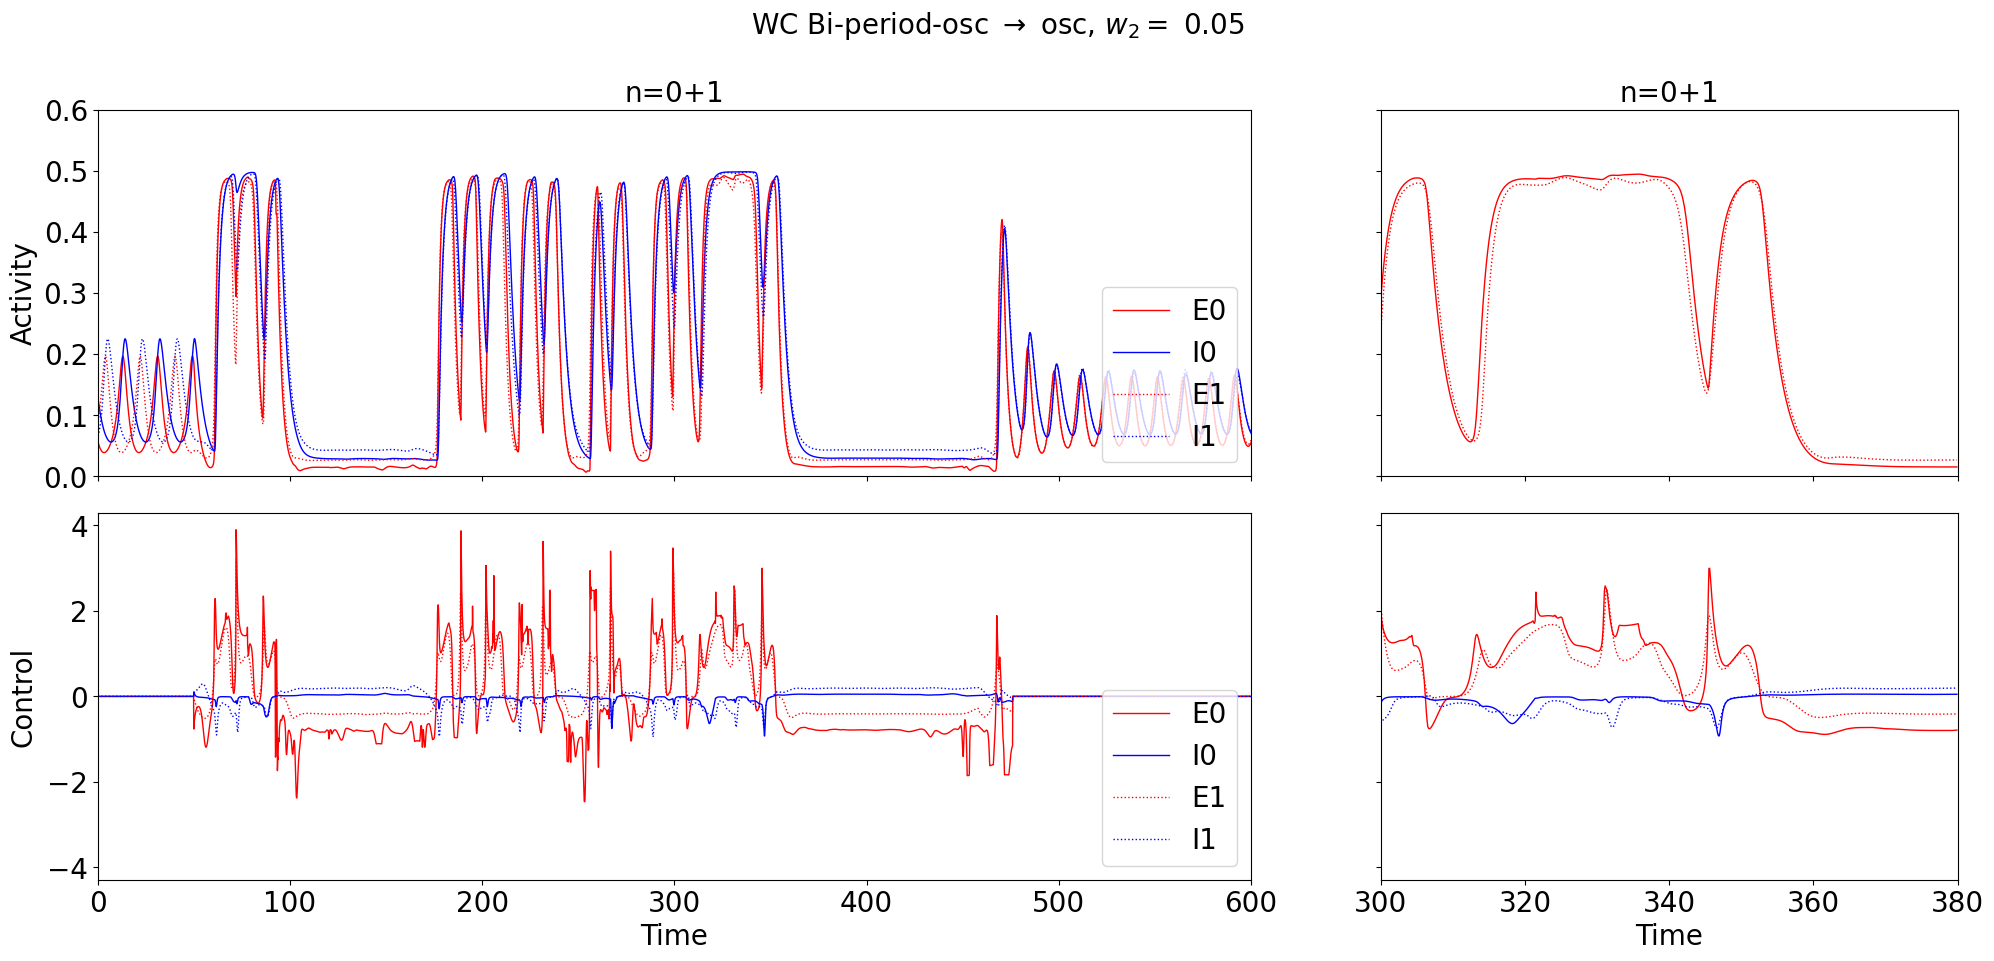

[0.05, 0.5]


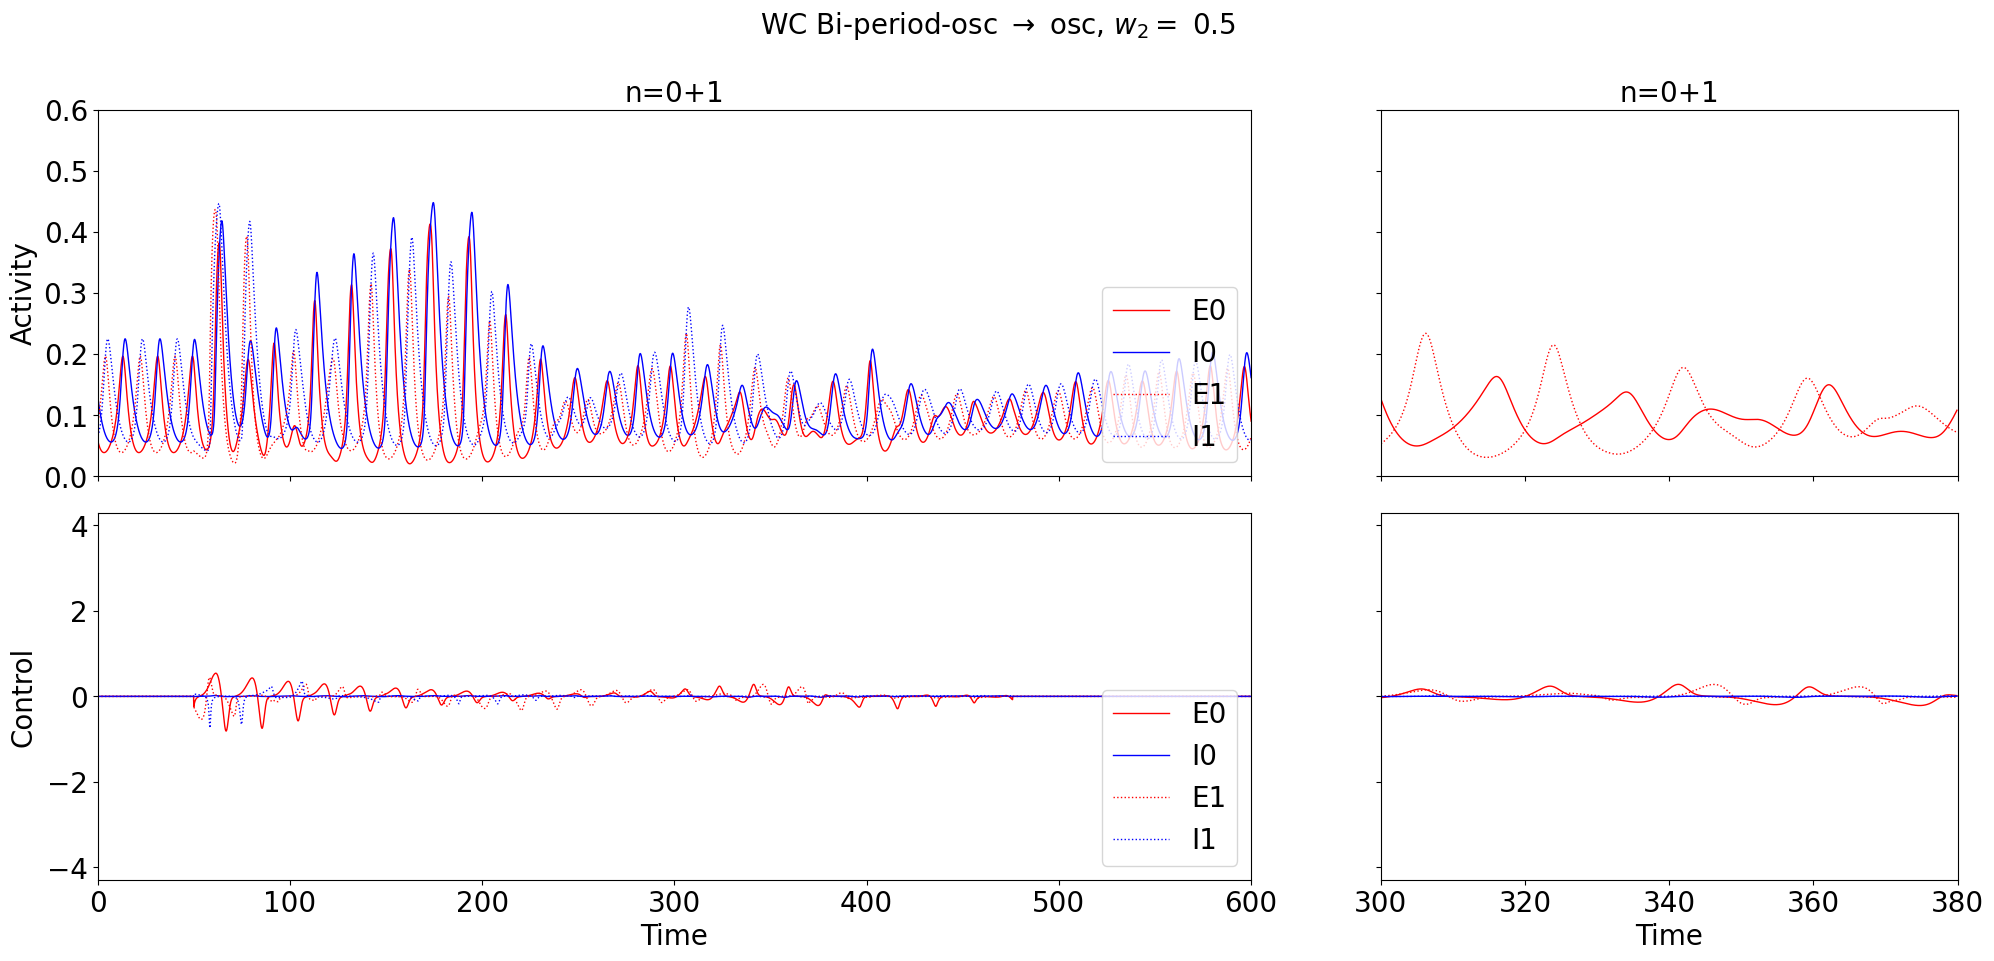

[0.05, 0.5]


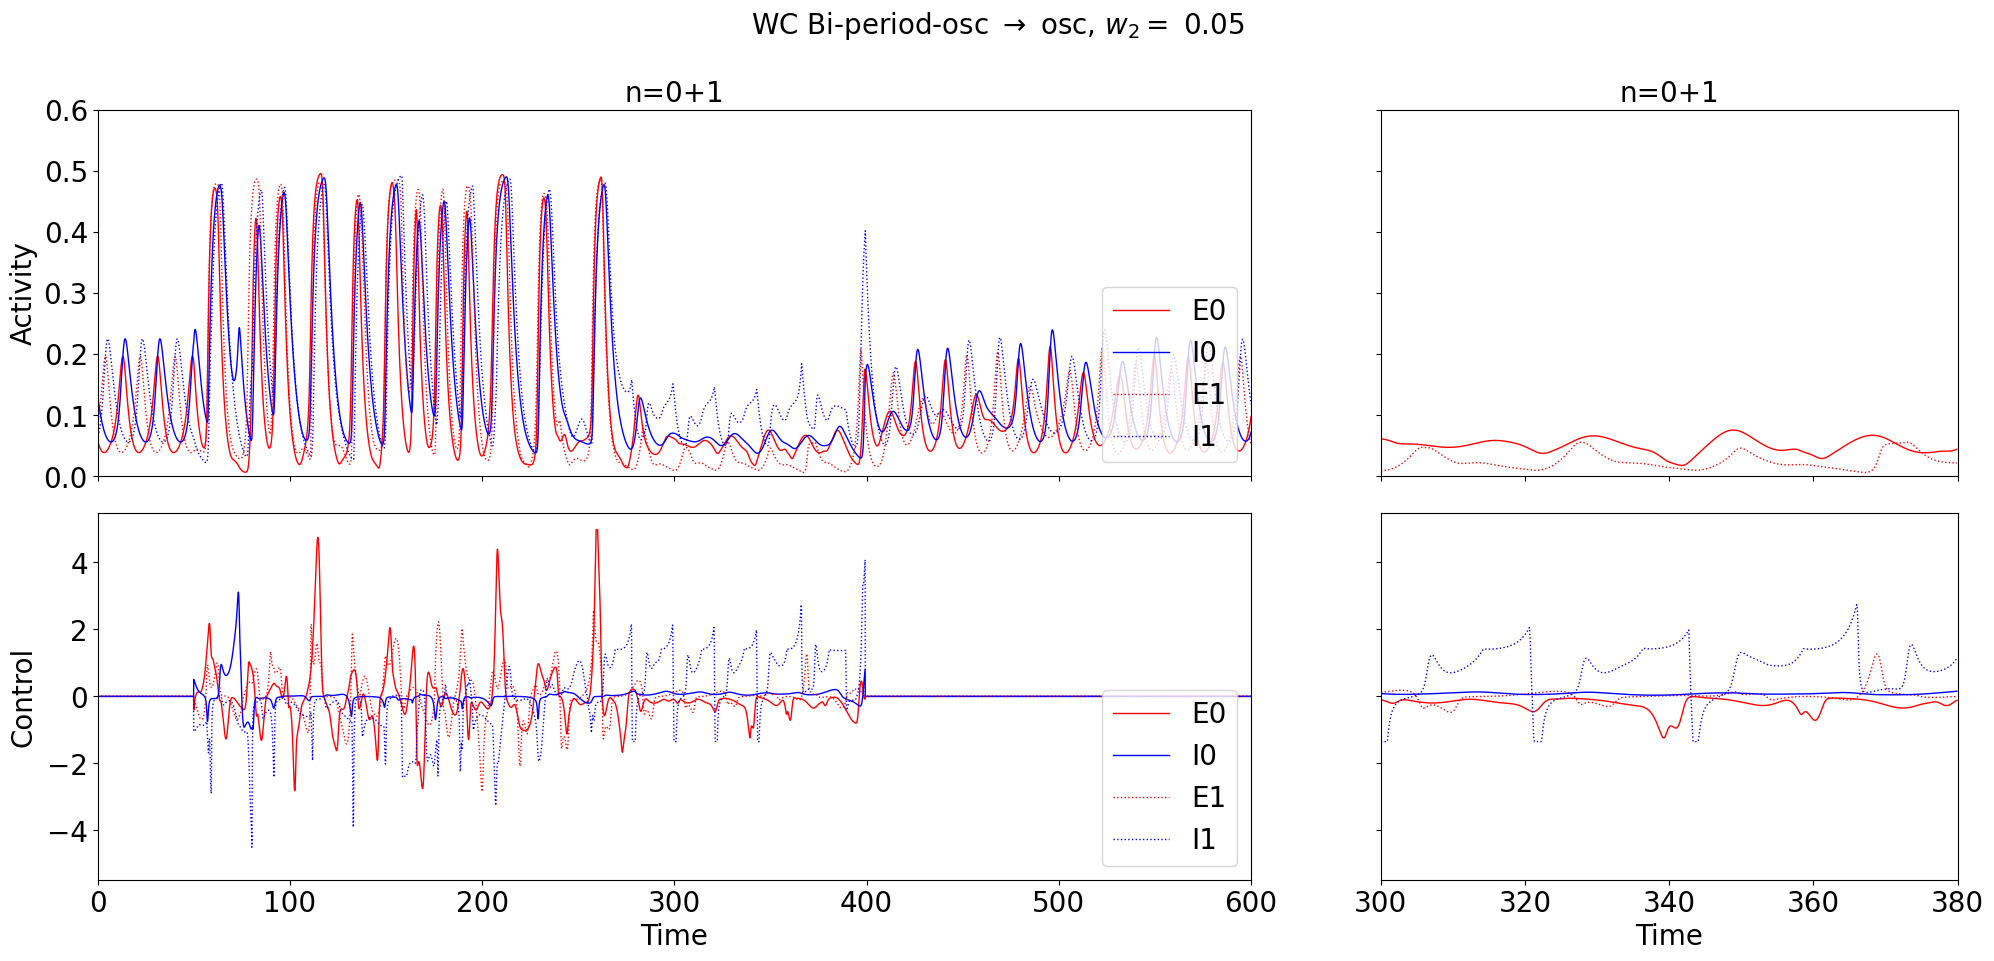

[0.05, 0.5]


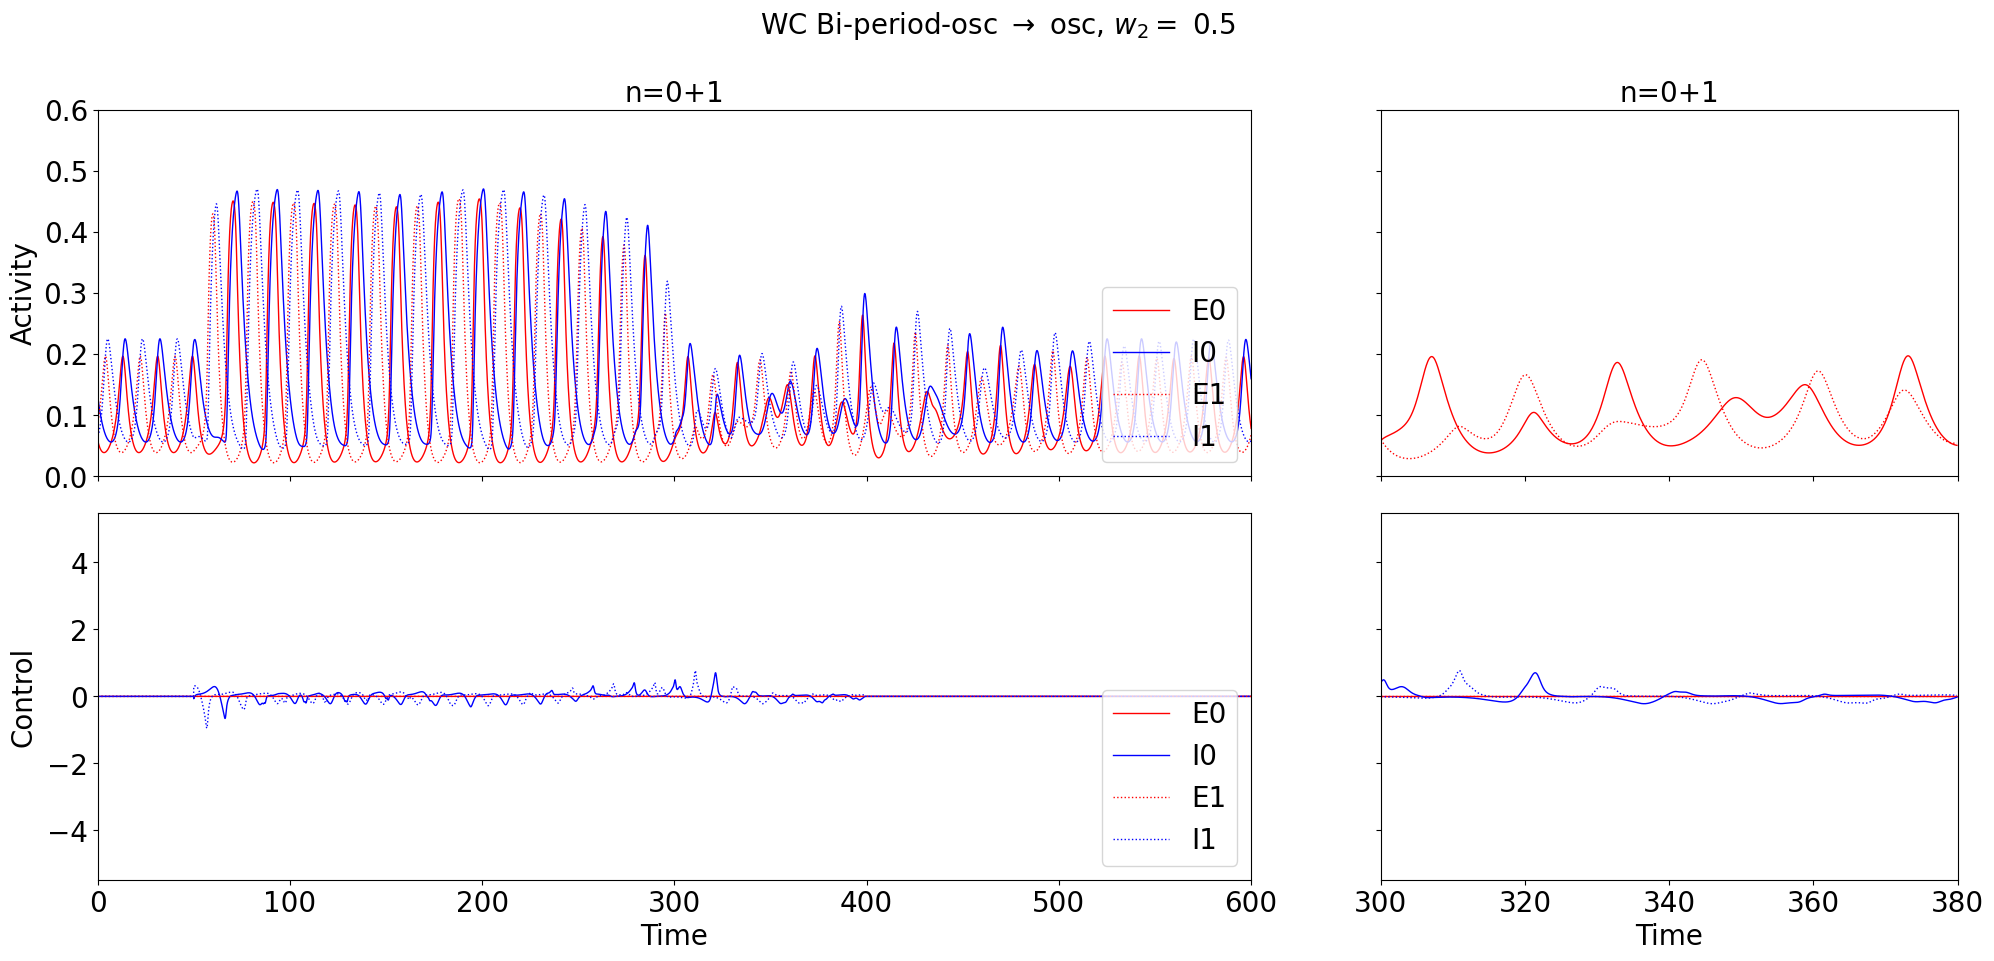

In [13]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" not in p:
        continue

    print("Point ", p)   

    for i_init in range(2):

        for wi in range(len(data[p]["weight"])):

            print(data[p]["weight"][wi])

            filename = os.path.join(dir, str(p) + "_" + str(i_init) + "_" + str(wi) + ".png")
            title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][i_init][wi])
            plot_control_bi(data[p],  data[p]["dur/per"][i_init][0], dt, wi, i_init, filename=filename, title=title)